# Multivariate time series for energy prediction

In [1]:
# import necessary Python packages
import statsmodels.api as sm
import warnings
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

%matplotlib inline
 
warnings.filterwarnings("ignore")
import pandas as pd
pd.plotting.register_matplotlib_converters()
import numpy as np
np.random.seed(1234)
import seaborn as sns

import plotly.express as px
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from IPython.display import Image, display

from prophet import Prophet

In [2]:
#pip install Prophet

In [3]:
#edata = pd.read_csv("energydata.csv", index_col="date", parse_dates= [True])

edata = pd.read_csv("energydata.csv")

#d_parser= lambda x: pd.datetime.strptime(x, '%d-%m-%Y %H-%M')
#edata = pd.read_csv("energydata.csv", parse_dates=['date'], date_parser= d_parser)

In [4]:
edata.loc[0,'date']

'11/Jan/2016 17:00'

In [5]:
edata.loc[19734,'date']

'27/May/2016 18:00'

In [6]:
#edata['date']=pd.to_datetime(edata['date'])
#edata.sort_values('date', inplace=True)

#edata['date']=pd.to_datetime(edata['date'], format= '%d-%m-%Y %H-%M')

edata['date']= pd.to_datetime(edata['date'])

In [7]:
print(edata)

                     date  appl  lgt      temp1       rh_1      temp2  \
0     2016-01-11 17:00:00    60   30  19.890000  47.596667  19.200000   
1     2016-01-11 17:10:00    60   30  19.890000  46.693333  19.200000   
2     2016-01-11 17:20:00    50   30  19.890000  46.300000  19.200000   
3     2016-01-11 17:30:00    50   40  19.890000  46.066667  19.200000   
4     2016-01-11 17:40:00    60   40  19.890000  46.333333  19.200000   
...                   ...   ...  ...        ...        ...        ...   
19730 2016-05-27 17:20:00   100    0  25.566667  46.560000  25.890000   
19731 2016-05-27 17:30:00    90    0  25.500000  46.500000  25.754000   
19732 2016-05-27 17:40:00   270   10  25.500000  46.596667  25.628571   
19733 2016-05-27 17:50:00   420   10  25.500000  46.990000  25.414000   
19734 2016-05-27 18:00:00   430   10  25.500000  46.600000  25.264286   

            rh_2      temp3       rh_3      temp4  ...      temp9     rh_9  \
0      44.790000  19.790000  44.730000  19.00

In [8]:
edata.loc[0,'date']

Timestamp('2016-01-11 17:00:00')

In [9]:
#edata['day_name'].value_counts()

In [10]:
edata['date'].min()

Timestamp('2016-01-11 17:00:00')

In [11]:
edata['date'].max()

Timestamp('2016-05-27 18:00:00')

In [12]:
edata['date'].max()-edata['date'].min() # to understand the number of days 

Timedelta('137 days 01:00:00')

In [13]:
edata.size

572315

In [14]:
edata.head()

date  appl  lgt  temp1       rh_1  temp2       rh_2  temp3  \
0 2016-01-11 17:00:00    60   30  19.89  47.596667   19.2  44.790000  19.79   
1 2016-01-11 17:10:00    60   30  19.89  46.693333   19.2  44.722500  19.79   
2 2016-01-11 17:20:00    50   30  19.89  46.300000   19.2  44.626667  19.79   
3 2016-01-11 17:30:00    50   40  19.89  46.066667   19.2  44.590000  19.79   
4 2016-01-11 17:40:00    60   40  19.89  46.333333   19.2  44.530000  19.79   

        rh_3      temp4  ...      temp9   rh_9  temp_out  press  rh_out  \
0  44.730000  19.000000  ...  17.033333  45.53      6.60  733.5    92.0   
1  44.790000  19.000000  ...  17.066667  45.56      6.48  733.6    92.0   
2  44.933333  18.926667  ...  17.000000  45.50      6.37  733.7    92.0   
3  45.000000  18.890000  ...  17.000000  45.40      6.25  733.8    92.0   
4  45.000000  18.890000  ...  17.000000  45.40      6.13  733.9    92.0   

   windspeed  visibility  dewpoint        rv1        rv2  
0   7.000000   63.000000       5.3  13.275433  13.275433  
1   6.666667   59.166667       5.2  18.606195  18.606195  
2   6.333333   55.333333       5.1  28.642668  28.642668  
3   6.000000   51.500000       5.0  45.410390  45.410390  
4   5.666667   47.666667       4.9  10.084097  10.084097  

[5 rows x 29 columns]

In [15]:
edata.tail()

date  appl  lgt      temp1       rh_1      temp2  \
19730 2016-05-27 17:20:00   100    0  25.566667  46.560000  25.890000   
19731 2016-05-27 17:30:00    90    0  25.500000  46.500000  25.754000   
19732 2016-05-27 17:40:00   270   10  25.500000  46.596667  25.628571   
19733 2016-05-27 17:50:00   420   10  25.500000  46.990000  25.414000   
19734 2016-05-27 18:00:00   430   10  25.500000  46.600000  25.264286   

            rh_2      temp3       rh_3  temp4  ...  temp9     rh_9  temp_out  \
19730  42.025714  27.200000  41.163333   24.7  ...   23.2  46.7900      22.7   
19731  42.080000  27.133333  41.223333   24.7  ...   23.2  46.7900      22.6   
19732  42.768571  27.050000  41.690000   24.7  ...   23.2  46.7900      22.5   
19733  43.036000  26.890000  41.290000   24.7  ...   23.2  46.8175      22.3   
19734  42.971429  26.823333  41.156667   24.7  ...   23.2  46.8450      22.2   

       press     rh_out  windspeed  visibility  dewpoint        rv1        rv2  
19730  755.2  55.666667   3.333333   23.666667      13.3  43.096812  43.096812  
19731  755.2  56.000000   3.500000   24.500000      13.3  49.282940  49.282940  
19732  755.2  56.333333   3.666667   25.333333      13.3  29.199117  29.199117  
19733  755.2  56.666667   3.833333   26.166667      13.2   6.322784   6.322784  
19734  755.2  57.000000   4.000000   27.000000      13.2  34.118851  34.118851  

[5 rows x 29 columns]

# Descriptive Statistics 

In [16]:
edata.describe(include='all', datetime_is_numeric= True)

date          appl           lgt         temp1  \
count                19735  19735.000000  19735.000000  19735.000000   
mean   2016-03-20 05:30:00     97.694958      3.801875     21.686571   
min    2016-01-11 17:00:00     10.000000      0.000000     16.790000   
25%    2016-02-14 23:15:00     50.000000      0.000000     20.760000   
50%    2016-03-20 05:30:00     60.000000      0.000000     21.600000   
75%    2016-04-23 11:45:00    100.000000      0.000000     22.600000   
max    2016-05-27 18:00:00   1080.000000     70.000000     26.260000   
std                    NaN    102.524891      7.935988      1.606066   

               rh_1         temp2          rh_2         temp3          rh_3  \
count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean      40.259739     20.341219     40.420420     22.267611     39.242500   
min       27.023333     16.100000     20.463333     17.200000     28.766667   
25%       37.333333     18.790000     37.900000     20.790000     36.900000   
50%       39.656667     20.000000     40.500000     22.100000     38.530000   
75%       43.066667     21.500000     43.260000     23.290000     41.760000   
max       63.360000     29.856667     56.026667     29.236000     50.163333   
std        3.979299      2.192974      4.069813      2.006111      3.254576   

              temp4  ...         temp9          rh_9      temp_out  \
count  19735.000000  ...  19735.000000  19735.000000  19735.000000   
mean      20.855335  ...     19.485828     41.552401      7.412580   
min       15.100000  ...     14.890000     29.166667     -5.000000   
25%       19.530000  ...     18.000000     38.500000      3.670000   
50%       20.666667  ...     19.390000     40.900000      6.920000   
75%       22.100000  ...     20.600000     44.338095     10.400000   
max       26.200000  ...     24.500000     53.326667     26.100000   
std        2.042884  ...      2.014712      4.151497      5.318464   

              press        rh_out     windspeed    visibility      dewpoint  \
count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean     755.522602     79.750418      4.039752     38.330834      3.760995   
min      729.300000     24.000000      0.000000      1.000000     -6.600000   
25%      750.933333     70.333333      2.000000     29.000000      0.900000   
50%      756.100000     83.666667      3.666667     40.000000      3.430000   
75%      760.933333     91.666667      5.500000     40.000000      6.570000   
max      772.300000    100.000000     14.000000     66.000000     15.500000   
std        7.399441     14.901088      2.451221     11.794719      4.195248   

                rv1           rv2  
count  19735.000000  19735.000000  
mean      24.988033     24.988033  
min        0.005322      0.005322  
25%       12.497889     12.497889  
50%       24.897653     24.897653  
75%       37.583769     37.583769  
max       49.996530     49.996530  
std       14.496634     14.496634  

[8 rows x 29 columns]

In [17]:
#mean_by_weekday=edata.loc['2016', ['appl', 'weekday']].groupby('weekday').mean()
#mean_by_weekday

#daily_mask= edata['day_name'] == 'monday'
#edata[daily_mask].query('appl < 100').sort_values('month')

In [18]:
edata.dtypes

date          datetime64[ns]
appl                   int64
lgt                    int64
temp1                float64
rh_1                 float64
temp2                float64
rh_2                 float64
temp3                float64
rh_3                 float64
temp4                float64
rh_4                 float64
temp5                float64
rh_5                 float64
temp6                float64
rh_6                 float64
temp7                float64
rh_7                 float64
temp8                float64
rh_8                 float64
temp9                float64
rh_9                 float64
temp_out             float64
press                float64
rh_out               float64
windspeed            float64
visibility           float64
dewpoint             float64
rv1                  float64
rv2                  float64
dtype: object

In [19]:
edata.info() # checking for missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        19735 non-null  datetime64[ns]
 1   appl        19735 non-null  int64         
 2   lgt         19735 non-null  int64         
 3   temp1       19735 non-null  float64       
 4   rh_1        19735 non-null  float64       
 5   temp2       19735 non-null  float64       
 6   rh_2        19735 non-null  float64       
 7   temp3       19735 non-null  float64       
 8   rh_3        19735 non-null  float64       
 9   temp4       19735 non-null  float64       
 10  rh_4        19735 non-null  float64       
 11  temp5       19735 non-null  float64       
 12  rh_5        19735 non-null  float64       
 13  temp6       19735 non-null  float64       
 14  rh_6        19735 non-null  float64       
 15  temp7       19735 non-null  float64       
 16  rh_7        19735 non-

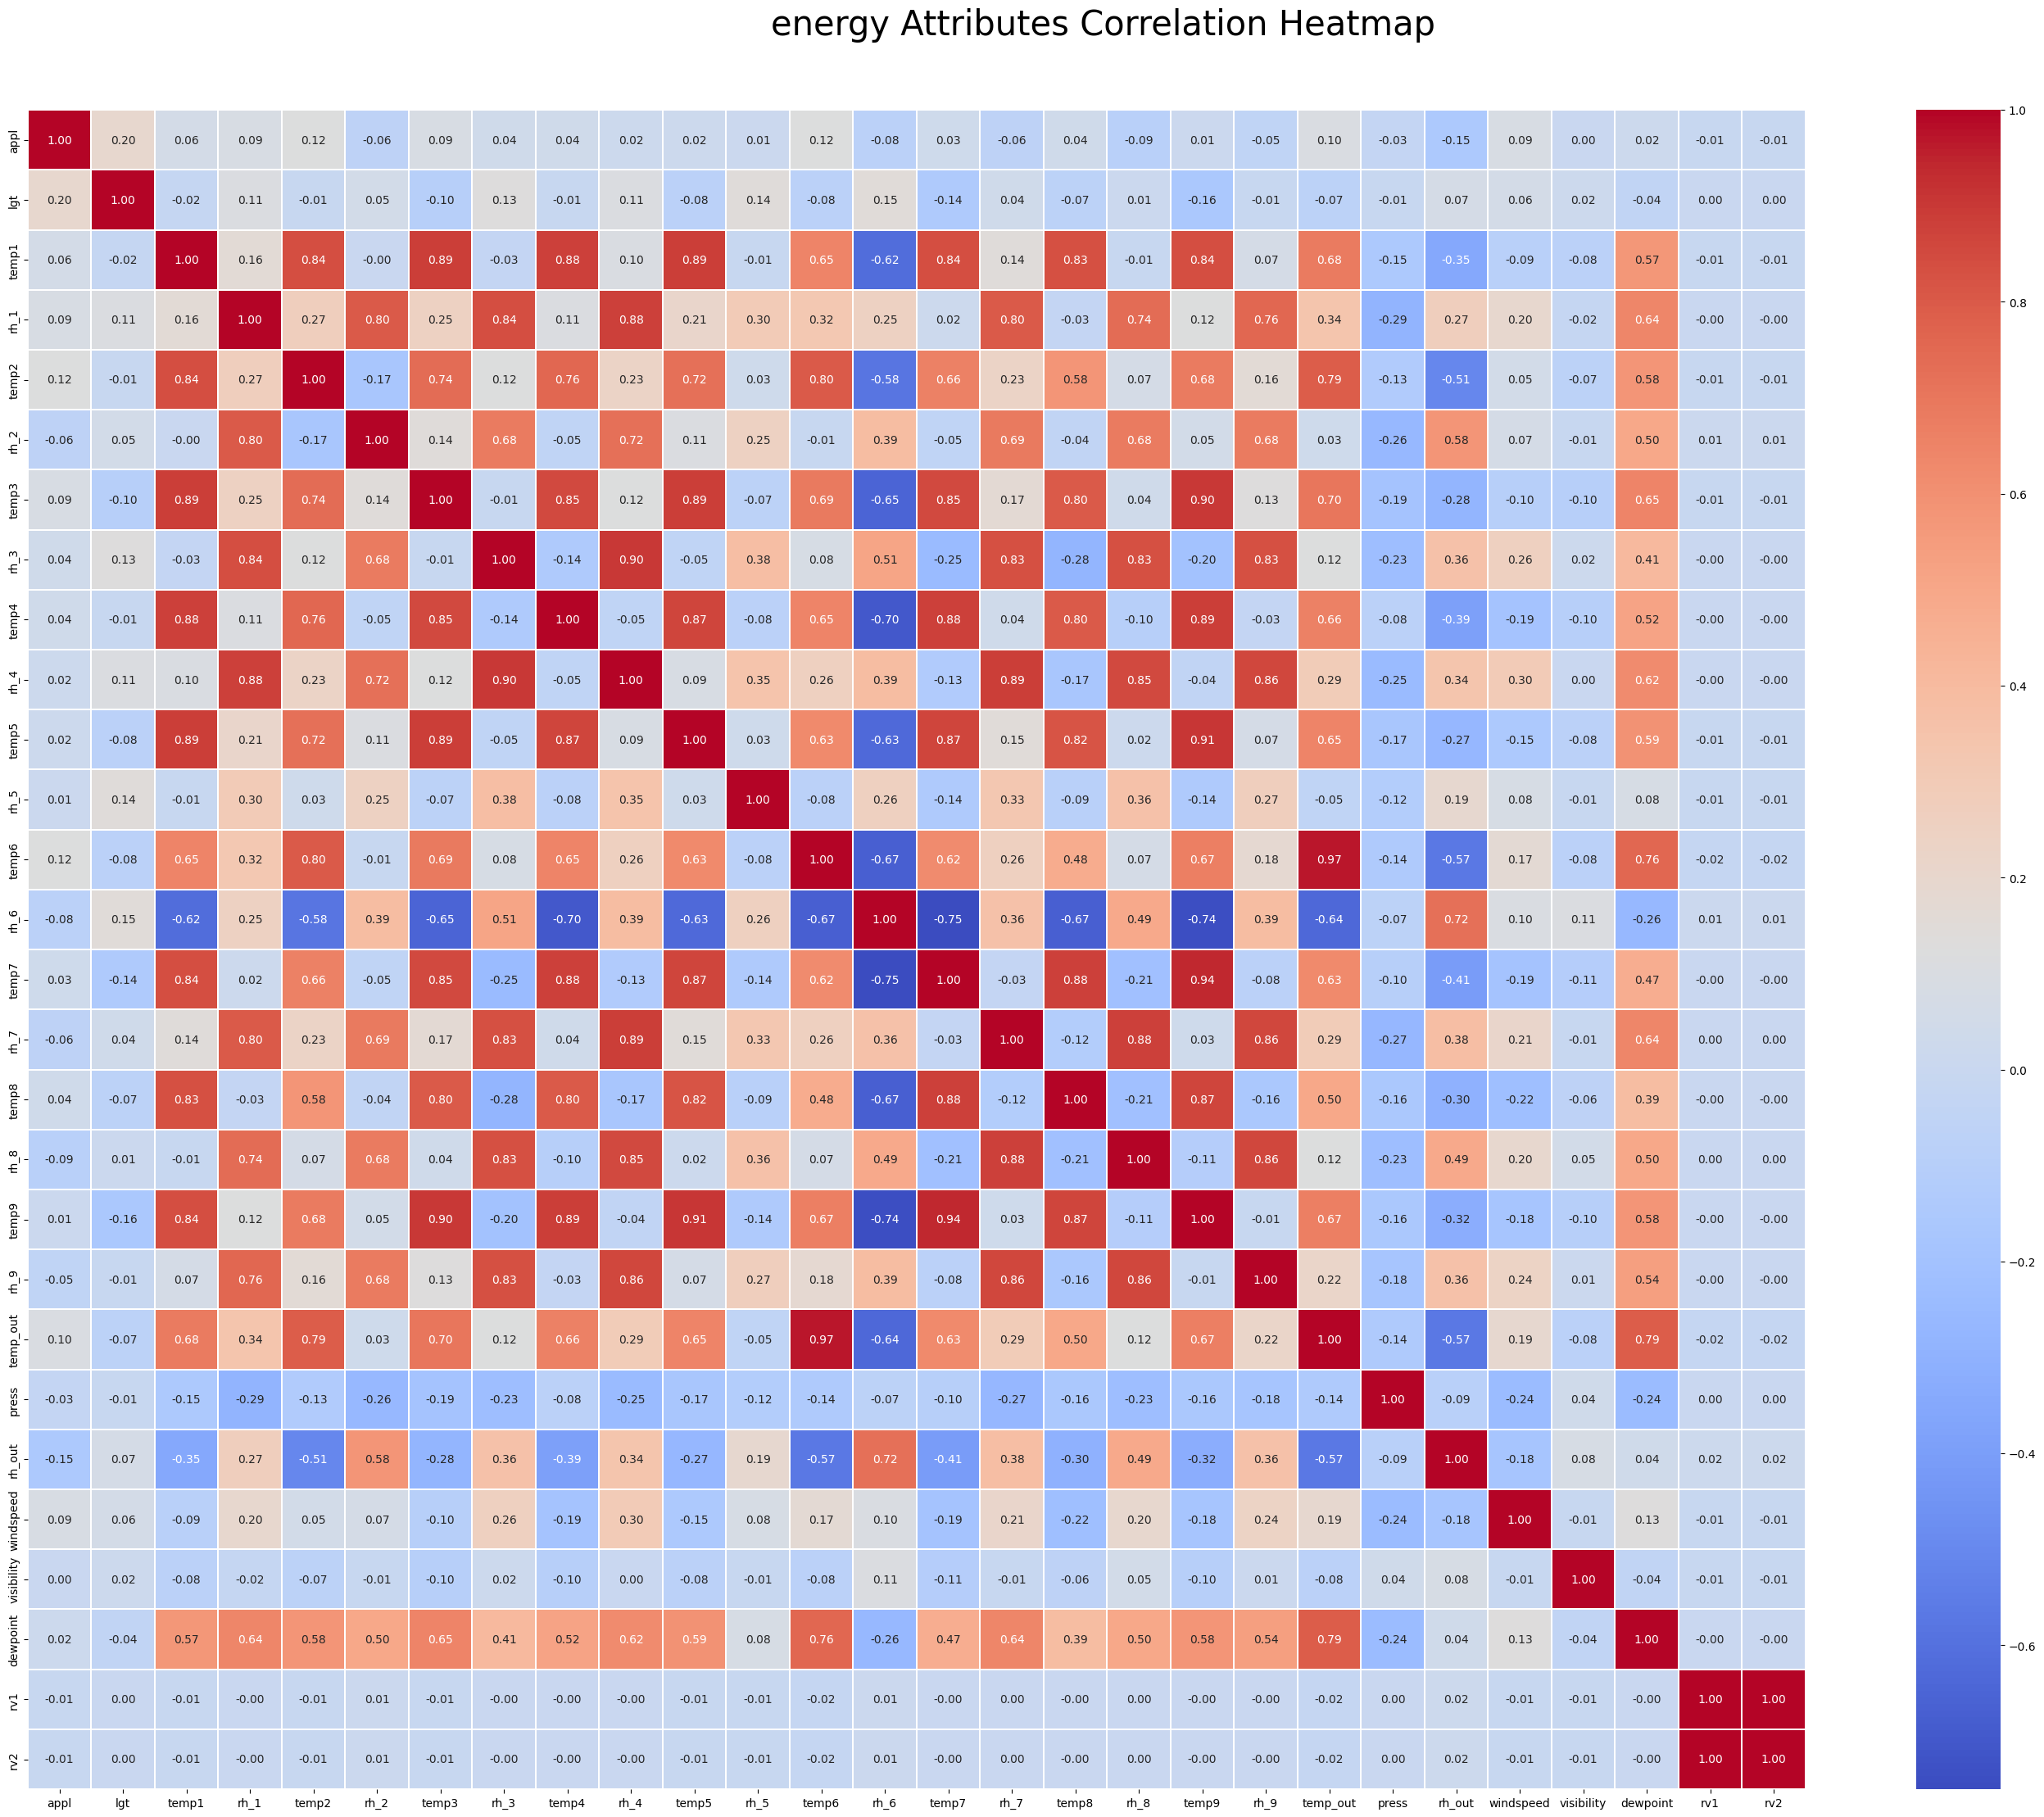

In [20]:
f, ax = plt.subplots(figsize=(35, 25))
corr = edata.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('energy Attributes Correlation Heatmap', fontsize=30)

In [21]:
edata.corr()

appl       lgt     temp1      rh_1     temp2      rh_2  \
appl        1.000000  0.197278  0.055447  0.086031  0.120073 -0.060465   
lgt         0.197278  1.000000 -0.023528  0.106968 -0.005622  0.050985   
temp1       0.055447 -0.023528  1.000000  0.164006  0.836834 -0.002509   
rh_1        0.086031  0.106968  0.164006  1.000000  0.269839  0.797535   
temp2       0.120073 -0.005622  0.836834  0.269839  1.000000 -0.165610   
rh_2       -0.060465  0.050985 -0.002509  0.797535 -0.165610  1.000000   
temp3       0.085060 -0.097393  0.892402  0.253230  0.735245  0.137319   
rh_3        0.036292  0.131161 -0.028550  0.844677  0.121497  0.678326   
temp4       0.040281 -0.008859  0.877001  0.106180  0.762066 -0.047304   
rh_4        0.016965  0.114936  0.097861  0.880359  0.231563  0.721435   
temp5       0.019760 -0.078745  0.885247  0.205797  0.720550  0.110409   
rh_5        0.006955  0.141233 -0.014782  0.303258  0.029595  0.250271   
temp6       0.117638 -0.079029  0.654769  0.316141  0.801186 -0.009670   
rh_6       -0.083178  0.153756 -0.615045  0.245126 -0.580372  0.389933   
temp7       0.025801 -0.135347  0.838705  0.021397  0.663660 -0.051422   
rh_7       -0.055642  0.035069  0.135182  0.801122  0.229212  0.690584   
temp8       0.039572 -0.071458  0.825413 -0.030053  0.578191 -0.041023   
rh_8       -0.094039  0.012915 -0.006441  0.736196  0.068534  0.679777   
temp9       0.010010 -0.157592  0.844777  0.115263  0.675535  0.054544   
rh_9       -0.051462 -0.008766  0.071756  0.764001  0.157346  0.676467   
temp_out    0.099155 -0.074423  0.682854  0.340788  0.792247  0.033703   
press      -0.034885 -0.010576 -0.150574 -0.293957 -0.133028 -0.255646   
rh_out     -0.152282  0.068543 -0.345481  0.274126 -0.505291  0.584911   
windspeed   0.087122  0.060281 -0.087654  0.204932  0.052495  0.069190   
visibility  0.000230  0.020038 -0.076210 -0.021057 -0.069721 -0.005368   
dewpoint    0.015357 -0.036331  0.571333  0.639125  0.582632  0.499154   
rv1        -0.011145  0.000521 -0.006203 -0.000699 -0.011087  0.006275   
rv2        -0.011145  0.000521 -0.006203 -0.000699 -0.011087  0.006275   

               temp3      rh_3     temp4      rh_4  ...     temp9      rh_9  \
appl        0.085060  0.036292  0.040281  0.016965  ...  0.010010 -0.051462   
lgt        -0.097393  0.131161 -0.008859  0.114936  ... -0.157592 -0.008766   
temp1       0.892402 -0.028550  0.877001  0.097861  ...  0.844777  0.071756   
rh_1        0.253230  0.844677  0.106180  0.880359  ...  0.115263  0.764001   
temp2       0.735245  0.121497  0.762066  0.231563  ...  0.675535  0.157346   
rh_2        0.137319  0.678326 -0.047304  0.721435  ...  0.054544  0.676467   
temp3       1.000000 -0.011234  0.852778  0.122737  ...  0.901324  0.134602   
rh_3       -0.011234  1.000000 -0.140457  0.898978  ... -0.195270  0.833538   
temp4       0.852778 -0.140457  1.000000 -0.048650  ...  0.889439 -0.025549   
rh_4        0.122737  0.898978 -0.048650  1.000000  ... -0.044518  0.856591   
temp5       0.888169 -0.050062  0.871813  0.091812  ...  0.911055  0.072308   
rh_5       -0.066355  0.375422 -0.076489  0.352591  ... -0.138509  0.272197   
temp6       0.686882  0.076833  0.652350  0.259047  ...  0.667177  0.184424   
rh_6       -0.647672  0.514912 -0.703149  0.392178  ... -0.738940  0.391943   
temp7       0.847374 -0.250090  0.877763 -0.131204  ...  0.944776 -0.077690   
rh_7        0.172624  0.832685  0.043527  0.894301  ...  0.028055  0.858686   
temp8       0.795283 -0.283228  0.796256 -0.167066  ...  0.869338 -0.156820   
rh_8        0.044427  0.828822 -0.095192  0.847259  ... -0.113014  0.855812   
temp9       0.901324 -0.195270  0.889439 -0.044518  ...  1.000000 -0.008683   
rh_9        0.134602  0.833538 -0.025549  0.856591  ... -0.008683  1.000000   
temp_out    0.699420  0.118237  0.663479  0.293307  ...  0.668218  0.223282   
press      -0.189974 -0.233274 -0.075292 -0.250748  ... -0.156828 -0.183739   
rh_out     -0.281718  0.356192 -0.388602  0.336813  

In [22]:
edata['hour']=edata['date'].dt.hour
edata['dayofweek']=edata['date'].dt.dayofweek
edata['month']=edata['date'].dt.month
edata['year']=edata['date'].dt.year
edata['weekofyear']=edata['date'].dt.weekofyear

In [23]:
edata= edata.set_index('date').resample('H').mean().reset_index() #aggregating into hourly basis

In [24]:
edata.drop(['rv1','rv2'], axis=1, inplace=True)

In [25]:
edata.columns

Index(['date', 'appl', 'lgt', 'temp1', 'rh_1', 'temp2', 'rh_2', 'temp3',
       'rh_3', 'temp4', 'rh_4', 'temp5', 'rh_5', 'temp6', 'rh_6', 'temp7',
       'rh_7', 'temp8', 'rh_8', 'temp9', 'rh_9', 'temp_out', 'press', 'rh_out',
       'windspeed', 'visibility', 'dewpoint', 'hour', 'dayofweek', 'month',
       'year', 'weekofyear'],
      dtype='object')

In [26]:
edata2=edata[['date', 'appl', 'lgt',  'temp1', 'rh_1', 'temp2', 'rh_2', 'temp3',
       'rh_3', 'temp4', 'rh_4', 'temp5', 'rh_5', 'temp6', 'rh_6', 'temp7',
       'rh_7', 'temp8', 'rh_8', 'temp9', 'rh_9', 'temp_out', 'press', 'rh_out',
       'windspeed', 'visibility', 'dewpoint', 'hour', 'dayofweek', 'month',
       'year', 'weekofyear']]

In [27]:
edata2.head()

date        appl        lgt      temp1       rh_1      temp2  \
0 2016-01-11 17:00:00   55.000000  35.000000  19.890000  46.502778  19.200000   
1 2016-01-11 18:00:00  176.666667  51.666667  19.897778  45.879028  19.268889   
2 2016-01-11 19:00:00  173.333333  25.000000  20.495556  52.805556  19.925556   
3 2016-01-11 20:00:00  125.000000  35.000000  20.961111  48.453333  20.251111   
4 2016-01-11 21:00:00  103.333333  23.333333  21.311667  45.768333  20.587778   

        rh_2      temp3       rh_3      temp4  ...       press     rh_out  \
0  44.626528  19.790000  44.897778  18.932778  ...  733.750000  92.000000   
1  44.438889  19.770000  44.863333  18.908333  ...  734.266667  91.583333   
2  46.061667  20.052222  47.227361  18.969444  ...  734.791667  89.750000   
3  45.632639  20.213889  47.268889  19.190833  ...  735.283333  87.583333   
4  44.961111  20.373333  46.164444  19.425556  ...  735.566667  87.416667   

   windspeed  visibility  dewpoint  hour  dayofweek  month    year  weekofyear  
0   6.166667   53.416667  5.050000  17.0        0.0    1.0  2016.0         2.0  
1   5.416667   40.000000  4.658333  18.0        0.0    1.0  2016.0         2.0  
2   6.000000   40.000000  4.391667  19.0        0.0    1.0  2016.0         2.0  
3   6.000000   40.000000  4.016667  20.0        0.0    1.0  2016.0         2.0  
4   6.000000   40.000000  3.816667  21.0        0.0    1.0  2016.0         2.0  

[5 rows x 32 columns]

In [28]:
edata2.corr()

appl       lgt     temp1      rh_1     temp2      rh_2  \
appl        1.000000  0.261794  0.074464  0.124464  0.155150 -0.068758   
lgt         0.261794  1.000000 -0.026813  0.126733 -0.005890  0.059116   
temp1       0.074464 -0.026813  1.000000  0.165936  0.838470 -0.002162   
rh_1        0.124464  0.126733  0.165936  1.000000  0.273126  0.802405   
temp2       0.155150 -0.005890  0.838470  0.273126  1.000000 -0.163754   
rh_2       -0.068758  0.059116 -0.002162  0.802405 -0.163754  1.000000   
temp3       0.116838 -0.111662  0.893731  0.256216  0.737472  0.138189   
rh_3        0.053693  0.151652 -0.028615  0.853102  0.122056  0.681418   
temp4       0.055205 -0.009062  0.878618  0.108033  0.764181 -0.046707   
rh_4        0.023247  0.131232  0.098747  0.889096  0.232799  0.724197   
temp5       0.024828 -0.090437  0.887927  0.209452  0.723937  0.111617   
rh_5        0.002012  0.166671 -0.015936  0.321630  0.030567  0.263501   
temp6       0.150774 -0.089949  0.656491  0.320266  0.802628 -0.007773   
rh_6       -0.107556  0.176334 -0.616571  0.246907 -0.581416  0.390135   
temp7       0.034945 -0.154925  0.839550  0.022510  0.665601 -0.051116   
rh_7       -0.068052  0.041198  0.136569  0.809275  0.231033  0.693269   
temp8       0.050736 -0.081881  0.826086 -0.029690  0.579899 -0.040915   
rh_8       -0.117791  0.016327 -0.005217  0.744227  0.070163  0.682758   
temp9       0.014573 -0.180655  0.845884  0.117057  0.677538  0.055074   
rh_9       -0.061158 -0.008205  0.073044  0.772890  0.159187  0.679956   
temp_out    0.127452 -0.085029  0.684419  0.345143  0.793925  0.035637   
press      -0.044034 -0.012278 -0.150630 -0.296775 -0.133336 -0.256678   
rh_out     -0.194515  0.078925 -0.347438  0.277023 -0.507293  0.587301   
windspeed   0.112477  0.069831 -0.088512  0.208679  0.052163  0.071092   
visibility -0.003380  0.023114 -0.080553 -0.023672 -0.074087 -0.005989   
dewpoint    0.021073 -0.041451  0.573159  0.646007  0.584903  0.501629   
hour        0.274622  0.293839  0.179414  0.019148  0.255676 -0.183882   
dayofweek   0.004397 -0.114685  0.001691 -0.054071  0.000896 -0.044342   
month      -0.013179 -0.206002  0.707024 -0.094323  0.534957 -0.098052   
year             NaN       NaN       NaN       NaN       NaN       NaN   
weekofyear -0.012571 -0.214001  0.695670 -0.100293  0.514440 -0.089344   

               temp3      rh_3     temp4      rh_4  ...     press    rh_out  \
appl        0.116838  0.053693  0.055205  0.023247  ... -0.044034 -0.194515   
lgt        -0.111662  0.151652 -0.009062  0.131232  ... -0.012278  0.078925   
temp1       0.893731 -0.028615  0.878618  0.098747  ... -0.150630 -0.347438   
rh_1        0.256216  0.853102  0.108033  0.889096  ... -0.296775  0.277023   
temp2       0.737472  0.122056  0.764181  0.232799  ... -0.133336 -0.507293   
rh_2        0.138189  0.681418 -0.046707  0.724197  ... -0.256678  0.587301   
temp3       1.000000 -0.012625  0.854894  0.123753  ... -0.190087 -0.283662   
rh_3       -0.012625  1.000000 -0.140727  0.902182  ... -0.234016  0.358502   
temp4       0.854894 -0.140727  1.000000 -0.048021  ... -0.075435 -0.390931   
rh_4        0.123753  0.902182 -0.048021  1.000000  ... -0.251043  0.337585   
temp5       0.891344 -0.049953  0.875177  0.092896  ... -0.171405 -0.276509   
rh_5       -0.069731  0.392949 -0.080385  0.368645  ... -0.124759  0.194492   
temp6       0.688900  0.077650  0.654267  0.260477  ... -0.141771 -0.570711   
rh_6       -0.649519  0.516785 -0.705164  0.392180  ... -0.065900  0.721087   
temp7       0.848598 -0.250476  0.879343 -0.130452  ... -0.097710 -0.413334   
rh_7        0.173869  0.835598  0.044565  0.895941  ... -0.266090  0.378721   
temp8       0.796518 -0.284024  0.797825 -0.166745  ... -0.162915 -0.302261   
rh_8        0.045370  0.832368 -0.094510  0.849426  ... -0.225969  0.488422   
temp9       0.902650 -0.195533  0.891109 -0.043846  ... -0.156851 -0.320874   
rh_9        0.135662  0.837462 -0.024714  0.859285  ... -0.184059  

## Performing stationary test

In [29]:
from statsmodels.tsa.stattools import adfuller
adfuller(edata2['appl'])

(-8.948888280256897,
 8.833753129593984e-15,
 29,
 3260,
 {'1%': -3.432357502010421,
  '5%': -2.862426994644342,
  '10%': -2.567242166152283},
 36243.30001436084)

<AxesSubplot:title={'center':'appliance energy usage'}, xlabel='date'>

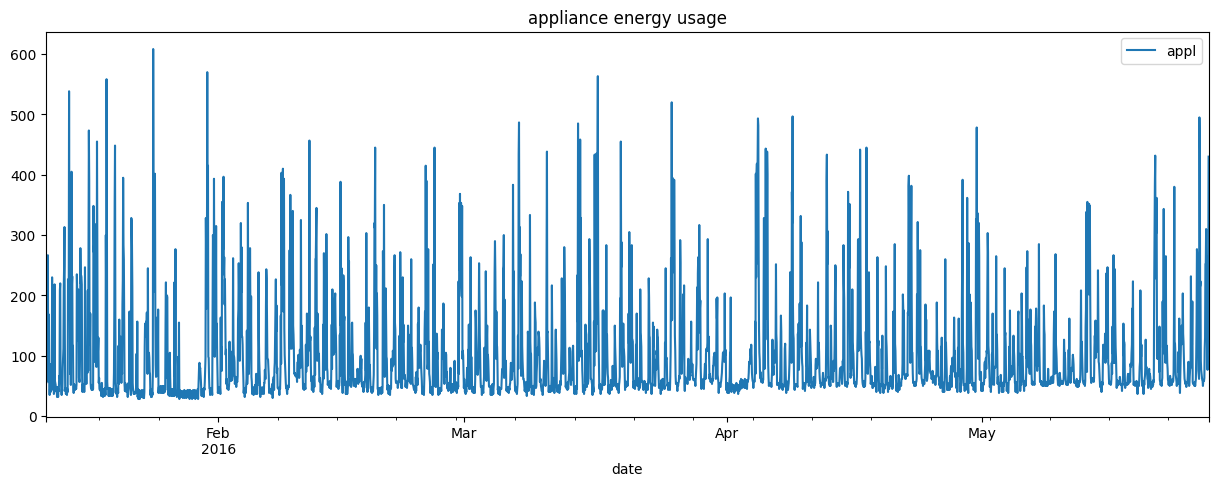

In [30]:
edata2.plot(kind='line', x='date', y='appl', figsize=(15,5), title='appliance energy usage')

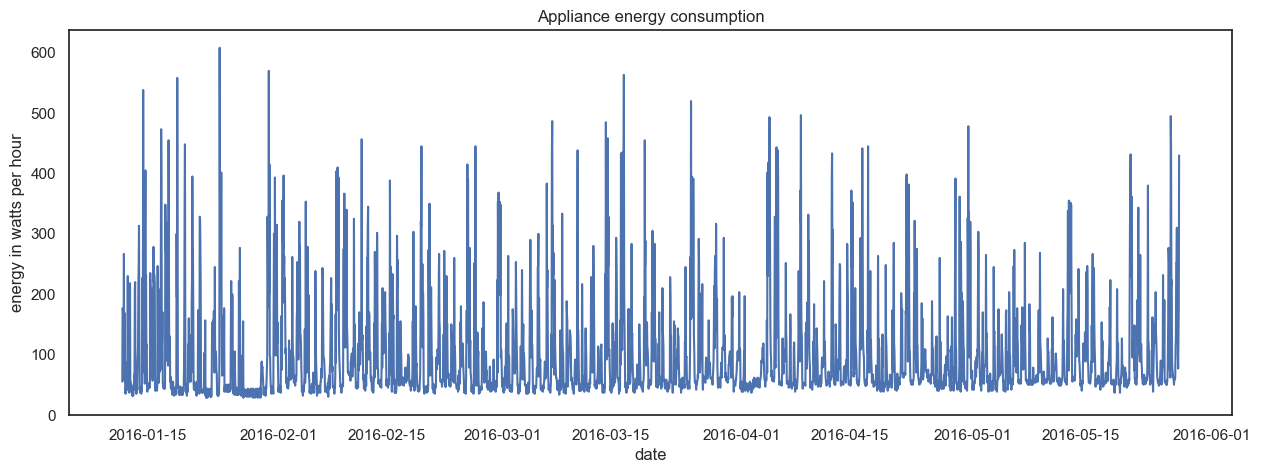

In [31]:
sns.set(rc={'figure.figsize':(15,5)}, style='white')
ax=sns.lineplot(data=edata2, x='date', y='appl')
ax.set_ylabel('energy in watts per hour')
ax.set_title('Appliance energy consumption')
plt.show()

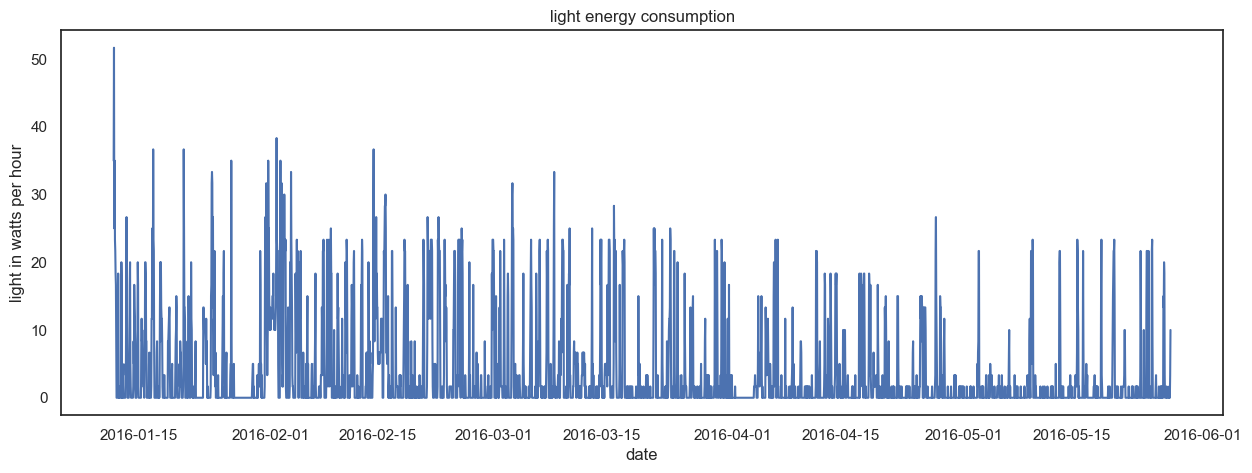

In [32]:
sns.set(rc={'figure.figsize':(15,5)}, style='white')
ax=sns.lineplot(data=edata2, x='date', y='lgt')
ax.set_ylabel('light in watts per hour')
ax.set_title('light energy consumption')
plt.show()

In [34]:
#converting dataframe into index
edata2.set_index('date', inplace=True)

# Time Series Decomposition

### Changing the frequency of the time by resampling technique 

In [35]:
edata2.resample('M').agg({'appl':'sum', 'lgt':'sum', 'temp8':'mean', 'temp_out':'mean','rh_out':'mean'})

appl          lgt      temp8   temp_out     rh_out
date                                                                  
2016-01-31  47251.666667  2300.000000  18.995378   4.129250  86.607461
2016-02-29  70258.333333  4415.000000  21.328102   4.817821  84.230125
2016-03-31  72133.333333  2913.333333  22.127827   5.439646  80.734991
2016-04-30  71200.000000  1740.000000  22.619655   8.514963  77.209954
2016-05-31  60850.000000  1145.000000  24.313614  13.775570  71.384007

In [36]:
#edata["appl_kwH"] = edata["appl"] / 1000 #converting the appliance from wH to kwH

In [37]:
edata2['January 2016']

appl        lgt      temp1       rh_1      temp2  \
date                                                                          
2016-01-11 17:00:00   55.000000  35.000000  19.890000  46.502778  19.200000   
2016-01-11 18:00:00  176.666667  51.666667  19.897778  45.879028  19.268889   
2016-01-11 19:00:00  173.333333  25.000000  20.495556  52.805556  19.925556   
2016-01-11 20:00:00  125.000000  35.000000  20.961111  48.453333  20.251111   
2016-01-11 21:00:00  103.333333  23.333333  21.311667  45.768333  20.587778   
...                         ...        ...        ...        ...        ...   
2016-01-31 19:00:00  118.333333  25.000000  22.685556  47.173333  22.159722   
2016-01-31 20:00:00  153.333333  25.000000  22.858889  46.108889  22.194444   
2016-01-31 21:00:00  100.000000  15.000000  22.963333  46.175278  22.043889   
2016-01-31 22:00:00   70.000000  11.666667  22.787222  46.371667  21.798889   
2016-01-31 23:00:00   38.333333  10.000000  22.433889  46.373889  21.473333   

                          rh_2      temp3       rh_3      temp4       rh_4  \
date                                                                         
2016-01-11 17:00:00  44.626528  19.790000  44.897778  18.932778  45.738750   
2016-01-11 18:00:00  44.438889  19.770000  44.863333  18.908333  46.066667   
2016-01-11 19:00:00  46.061667  20.052222  47.227361  18.969444  47.815556   
2016-01-11 20:00:00  45.632639  20.213889  47.268889  19.190833  49.227917   
2016-01-11 21:00:00  44.961111  20.373333  46.164444  19.425556  47.918889   
...                        ...        ...        ...        ...        ...   
2016-01-31 19:00:00  44.098472  21.735000  46.792778  19.950000  49.895556   
2016-01-31 20:00:00  43.961111  21.886667  46.596667  19.867778  50.469583   
2016-01-31 21:00:00  44.859444  21.890000  46.622083  19.806111  50.536111   
2016-01-31 22:00:00  45.600000  21.834444  46.691111  19.537222  50.056667   
2016-01-31 23:00:00  45.897778  21.707778  46.487778  19.345556  49.798333   

                     ...       press     rh_out  windspeed  visibility  \
date                 ...                                                 
2016-01-11 17:00:00  ...  733.750000  92.000000   6.166667   53.416667   
2016-01-11 18:00:00  ...  734.266667  91.583333   5.416667   40.000000   
2016-01-11 19:00:00  ...  734.791667  89.750000   6.000000   40.000000   
2016-01-11 20:00:00  ...  735.283333  87.583333   6.000000   40.000000   
2016-01-11 21:00:00  ...  735.566667  87.416667   6.000000   40.000000   
...                  ...         ...        ...        ...         ...   
2016-01-31 19:00:00  ...  752.925000  91.416667   7.583333   24.583333   
2016-01-31 20:00:00  ...  753.433333  93.250000   7.416667   39.833333   
2016-01-31 21:00:00  ...  754.066667  94.166667   8.000000   45.333333   
2016-01-31 22:00:00  ...  754.591667  94.250000   8.000000   30.750000   
2016-01-31 23:00:00  ...  755.208333  95.166667   8.000000   36.333333   

                      dewpoint  hour  dayofweek  month    year  weekofyear  
date                                                                        
2016-01-11 17:00:00   5.050000  17.0        0.0    1.0  2016.0         2.0  
2016-01-11 18:00:00   4.658333  18.0        0.0    1.0  2016.0         2.0  
2016-01-11 19:00:00   4.391667  19.0        0.0    1.0  2016.0         2.0  
2016-01-11 20:00:00   4.016667  20.0        0.0    1.0  2016.0         2.0  
2016-01-11 21:00:00   3.816667  21.0        0.0    1.0  2016.0         2.0  
...                        ...   ...        ...    ...     ...         ...  
2016-01-31 19:00:00  10.333333  19.0        6.0    1.0  2016.0         4.0  
2016-01-31 20:00:00  10.583333  20.0        6.0    1.0  2016.0         4.0  
2016-01-31 21:00:00  10.666667  21.0        6.0    1.0  2016.0         4.0  
2016-01-31 22:00:00  10.650000  22.0        6.0    1.0  2016.0         4.0  
2016-01-31 23:00:00  10.616667  23.0        6.0    1.0  2016.0         4.0  

[487 rows x 31 colu

In [38]:
months= ['January 2016', 'February 2016', 'March 2016', 'April 2016', 'May 2016']

### Power consumption distribution histogram and outlier detection

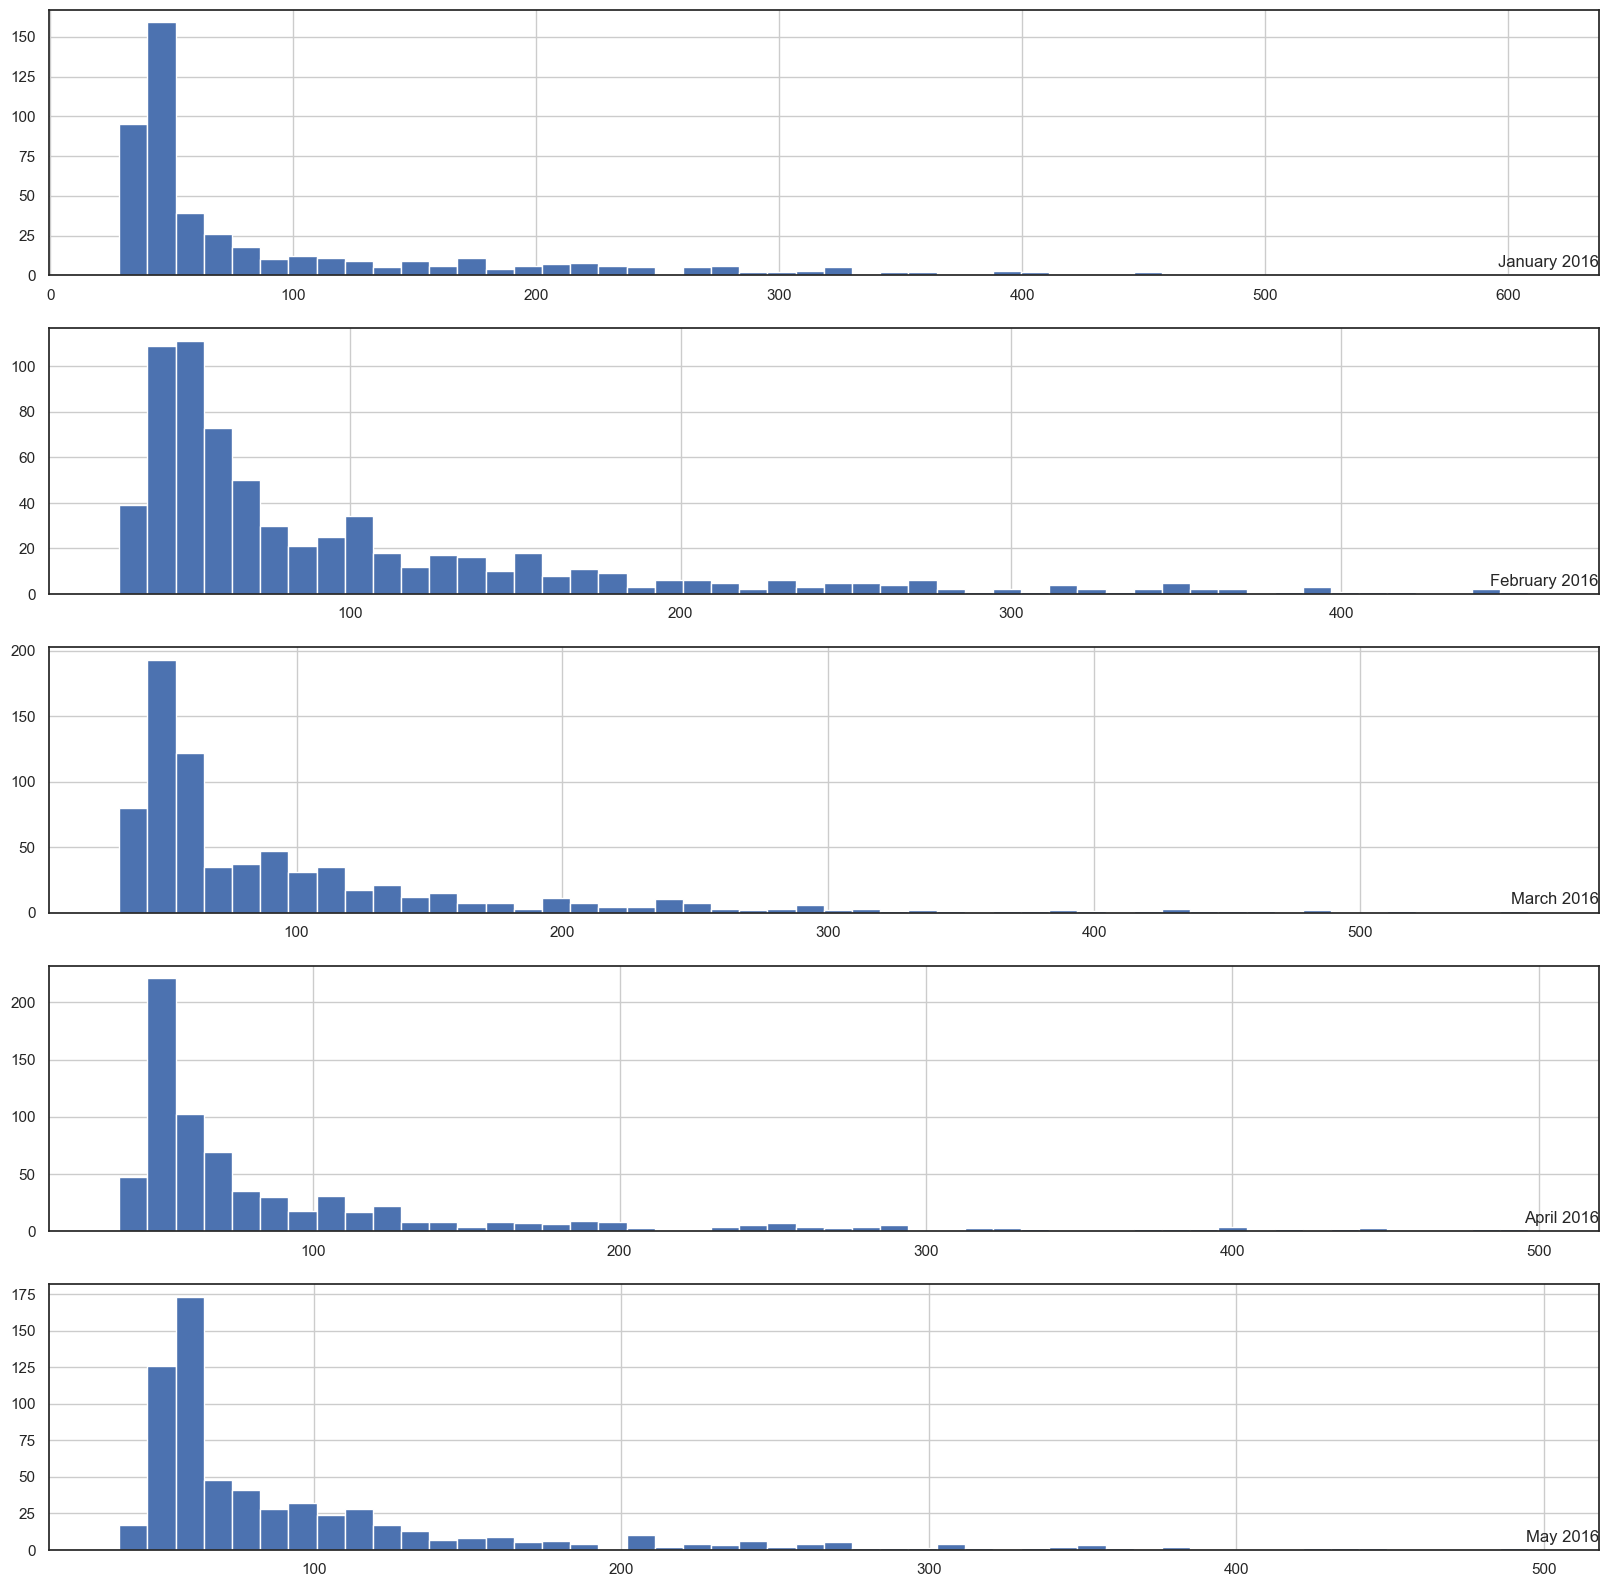

In [39]:
fig, ax= plt.subplots(figsize=(20,20))

for i in range (len(months)):
    plt.subplot(len(months), 1, i+1)
    month= months[i]
    monthly_usage= edata2[str(month)]
    monthly_usage['appl'].hist(bins= 50)
    plt.title(str(month), y=0, loc='right')
plt.show()
fig.tight_layout()

## Observing Trend,seasonlity and Noise

forecasting power for weeks
week1 to week2
week2 to week3
week3 to week4

## Exploring active power consumption for each month

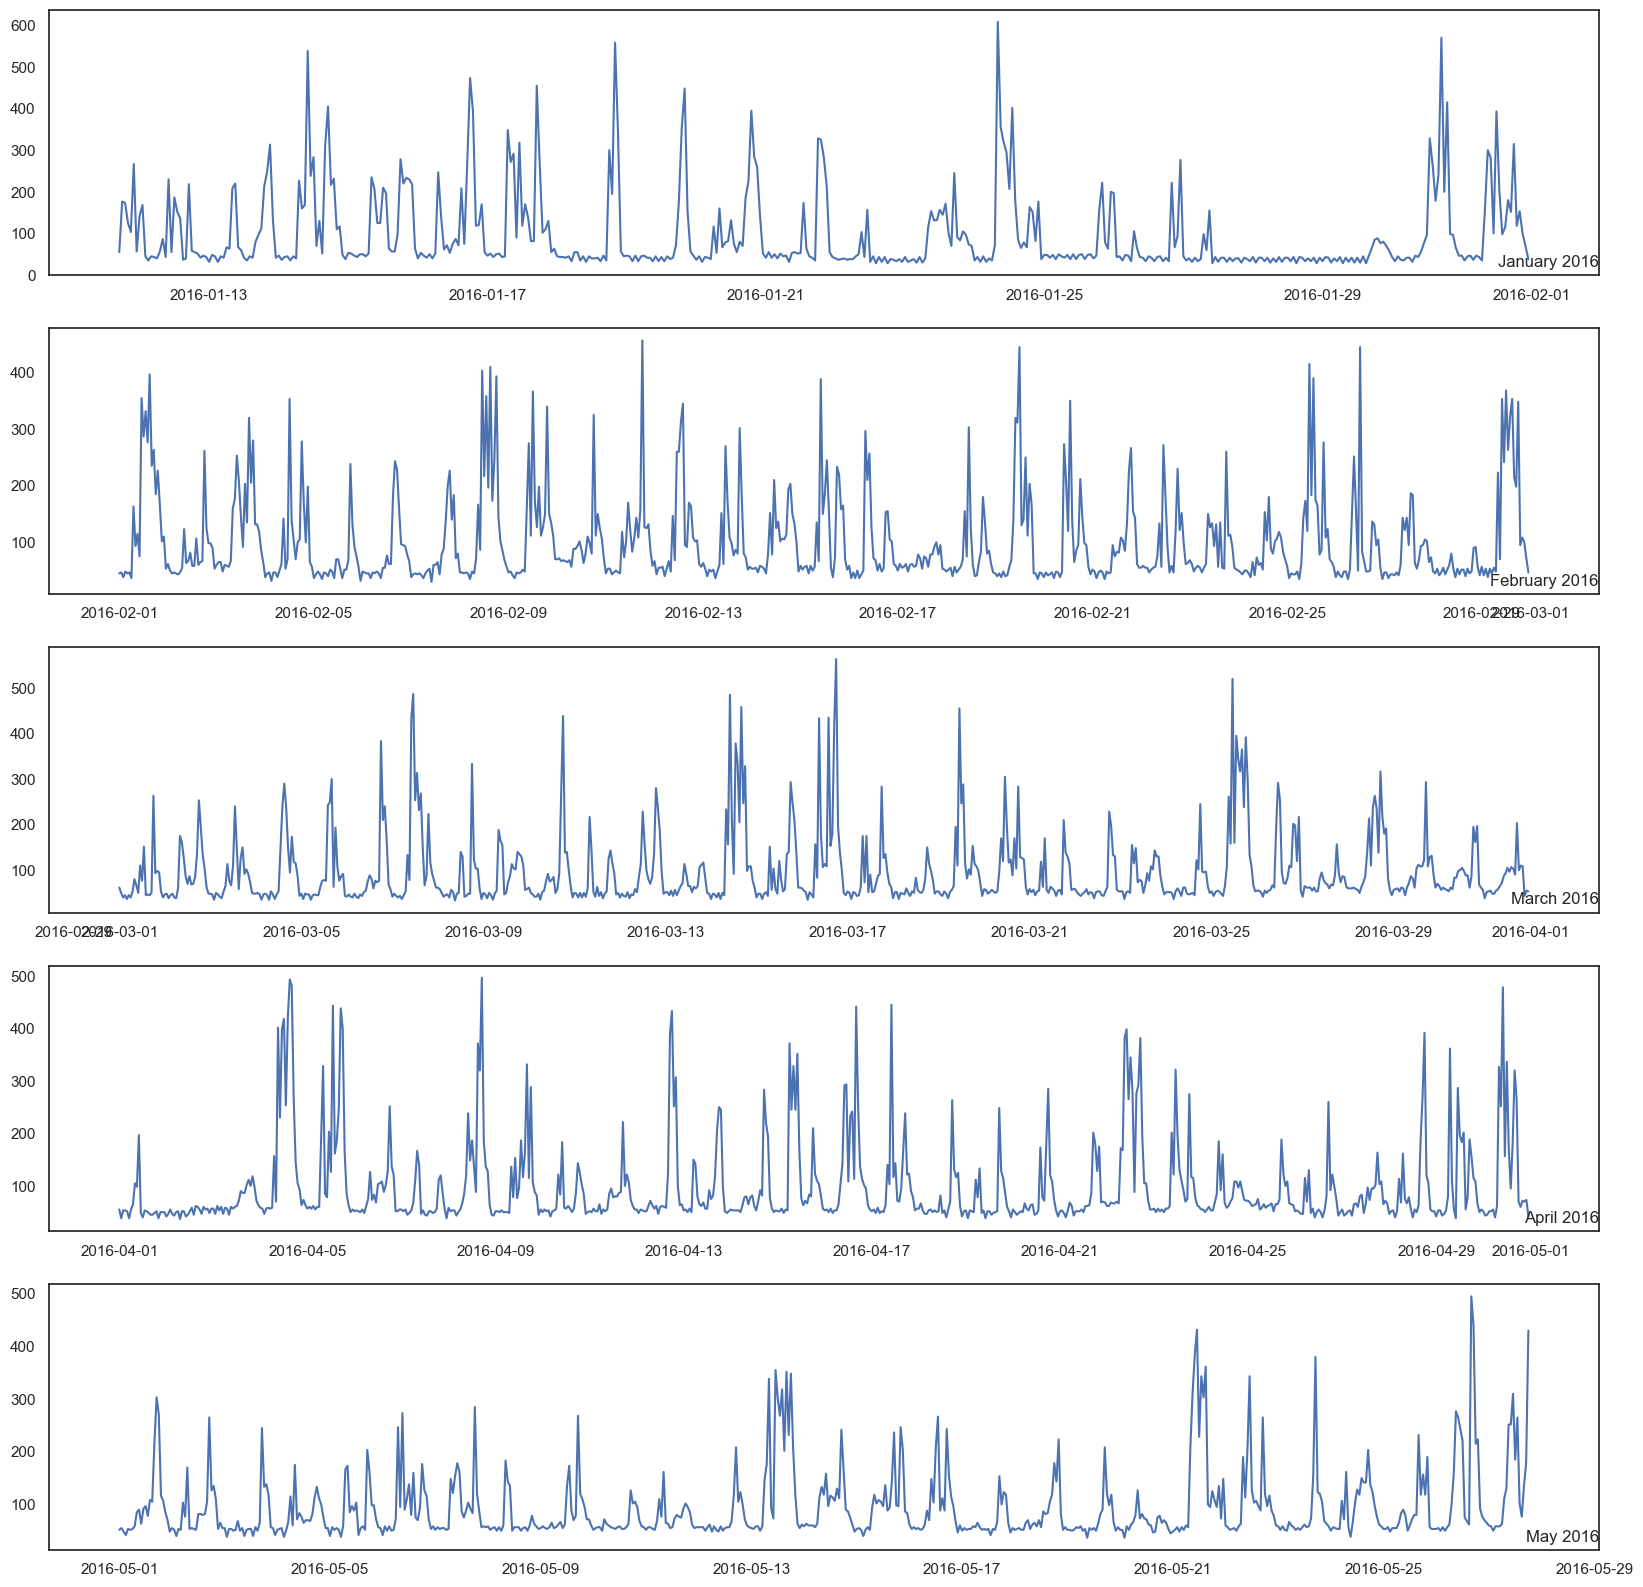

In [40]:
fig, ax=plt.subplots(figsize=(20,20))

for i in range (len(months)):
    plt.subplot(len(months), 1, i+1)
    month= months[i]
    monthly_usage= edata2[str(month)]
    plt.plot(monthly_usage['appl'])
    plt.title(str(month), y=0, loc='right')
plt.show()
fig.tight_layout()

# Decomposing time series

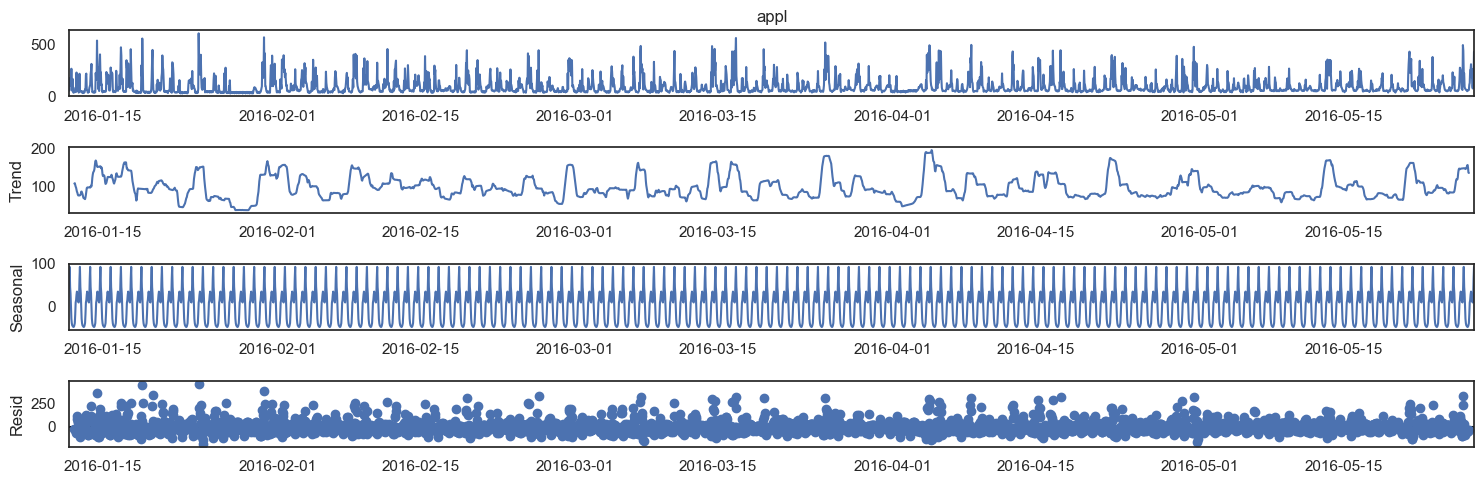

In [41]:
edata_appl = edata2['appl']
decomposition = sm.tsa.seasonal_decompose(edata_appl['2016-01-11':'2016-05-27'], model= 'additive')
 
fig = decomposition.plot()
matplotlib.rcParams['figure.figsize'] = [8.0, 6.0]
plt.savefig('output.png', dpi=300)

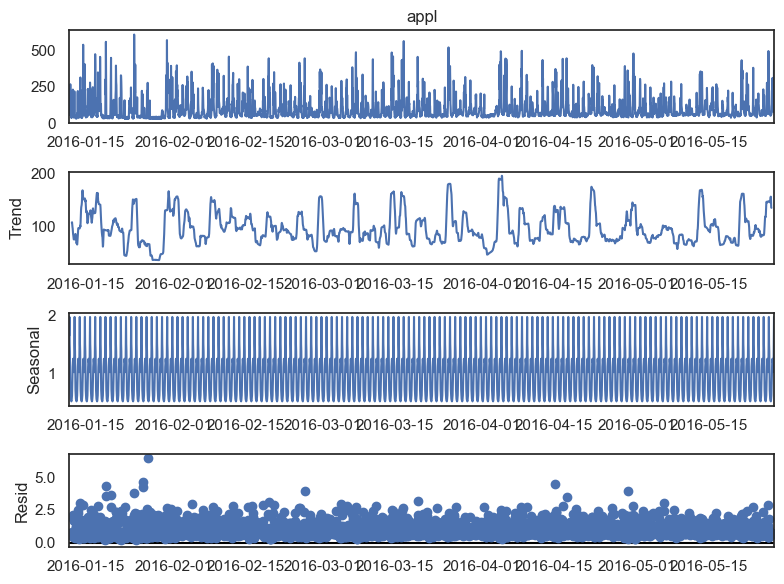

In [42]:
edata_appl2 = edata2['appl']
decomposition = sm.tsa.seasonal_decompose(edata_appl2['2016-01-11':'2016-05-27'], model= 'multiplicative')
 
fig = decomposition.plot()
matplotlib.rcParams['figure.figsize'] = [8.0, 6.0]

## Performing autocorrelation plots

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

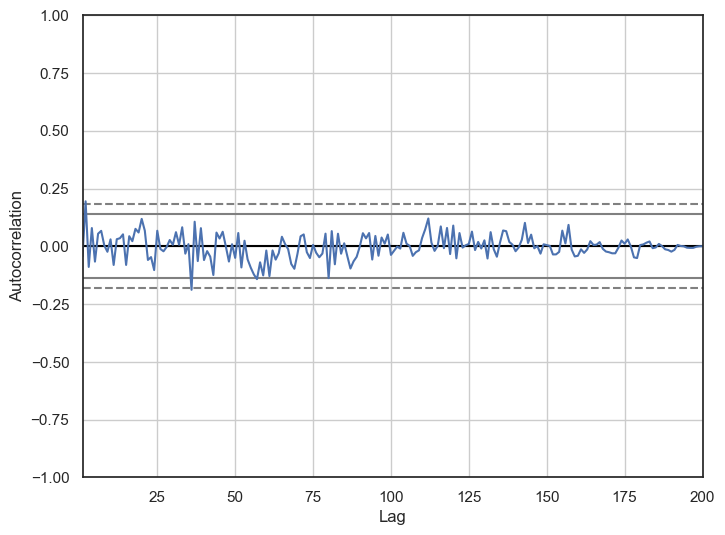

In [43]:
from pandas.plotting import autocorrelation_plot
np.random.seed(0) #will this repeatable
autocorrelation_plot(pd.Series(np.random.random(size=200)))

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

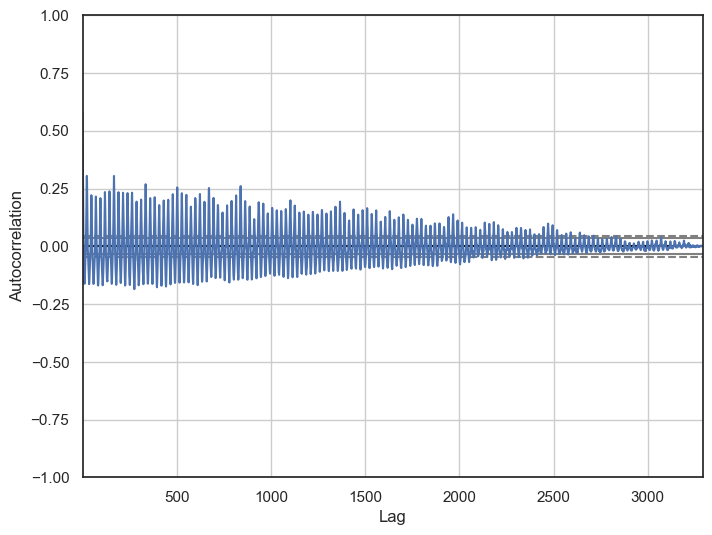

In [44]:
autocorrelation_plot(edata2.appl)

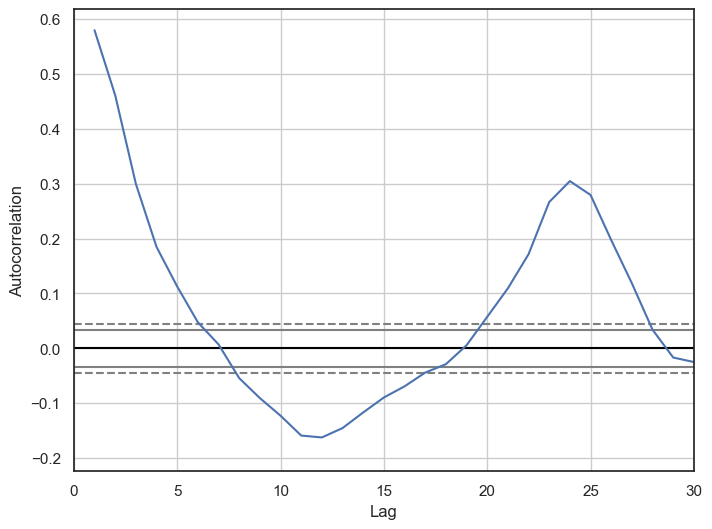

In [45]:
fig, ax=plt.subplots();
autocorrelation_plot(edata2.appl, ax=ax)
ax.set_xlim(0,30); # checking for autocoleration of 30 days interval i.e from monday to monday

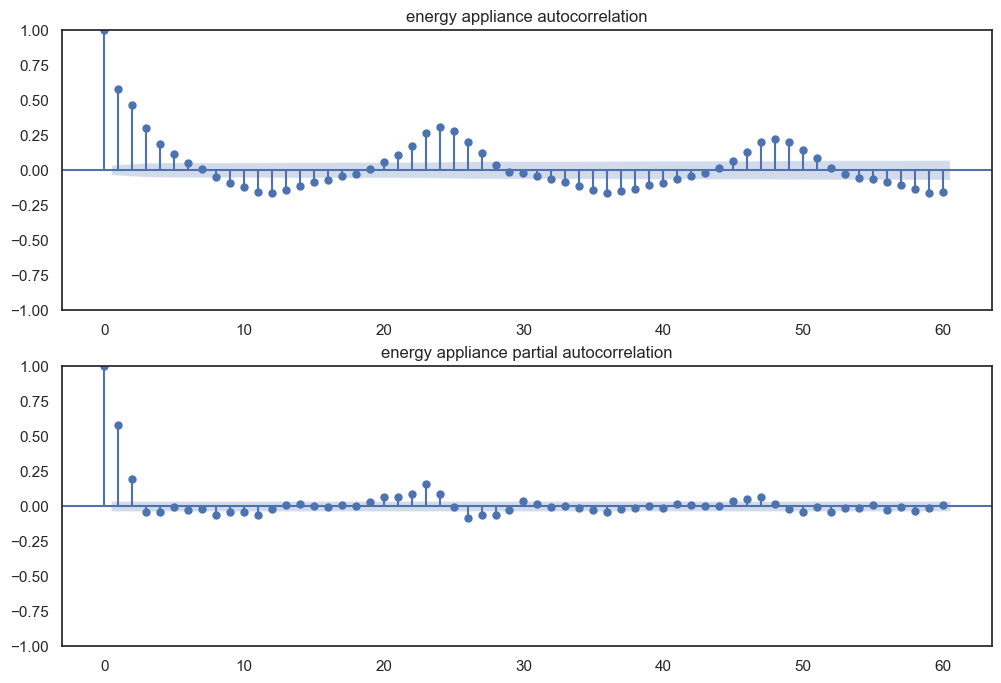

In [46]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(edata2['appl'],lags=60,ax=ax1, title='energy appliance autocorrelation')
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(edata2['appl'],lags=60,ax=ax2, title='energy appliance partial autocorrelation')

## Checking for lag

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

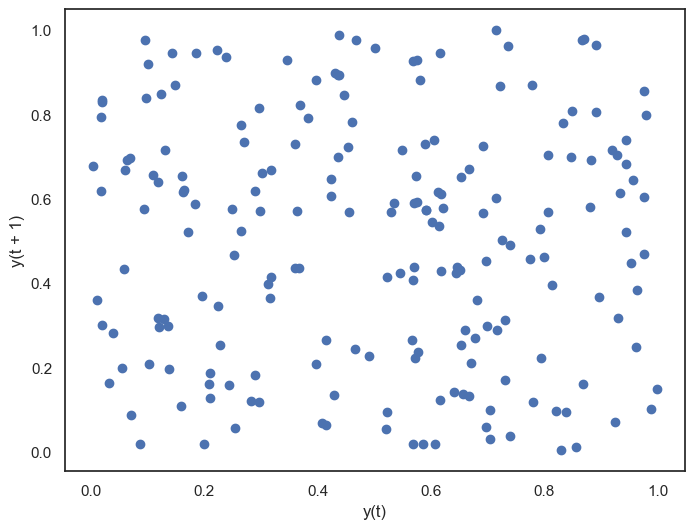

In [47]:
from pandas.plotting import lag_plot
np.random.seed(0) 
lag_plot(pd.Series(np.random.random(size=200)))

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

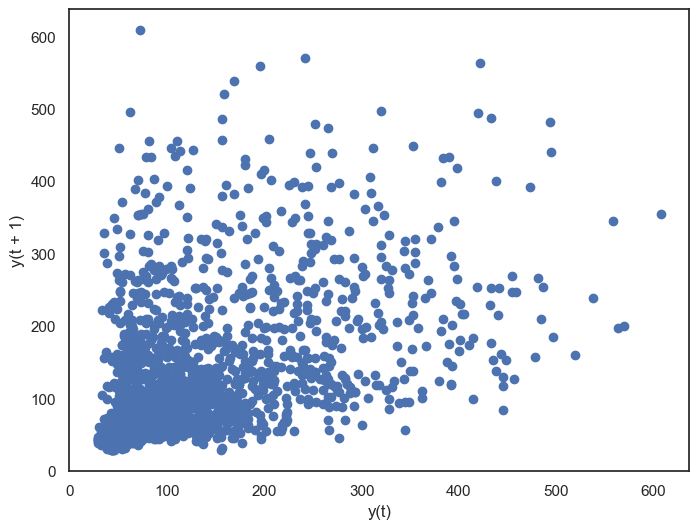

In [48]:
lag_plot(edata2.appl)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 4)'>

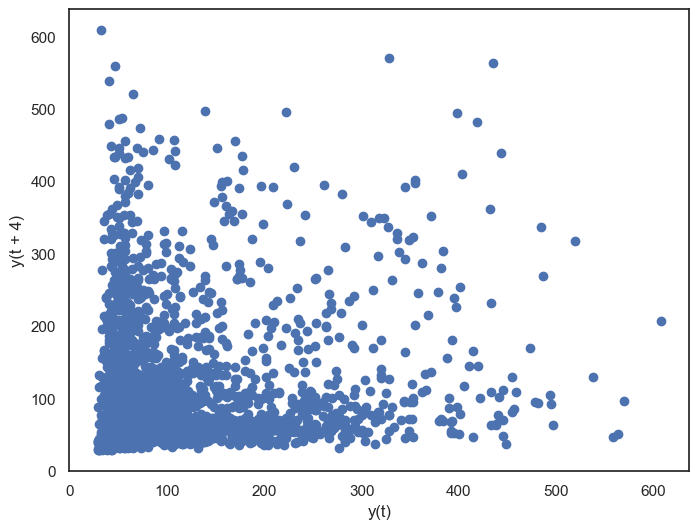

In [49]:
lag_plot(edata2.appl, lag=4)

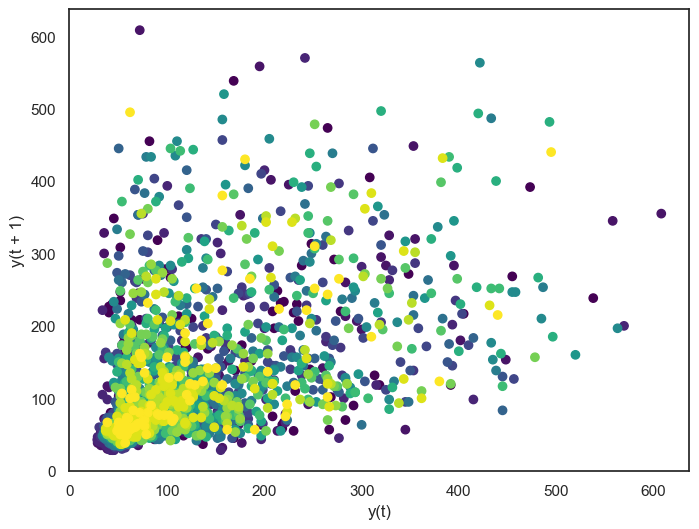

In [50]:
lag_plot(edata2['appl'],c=edata2['weekofyear'][:-1], cmap='viridis');

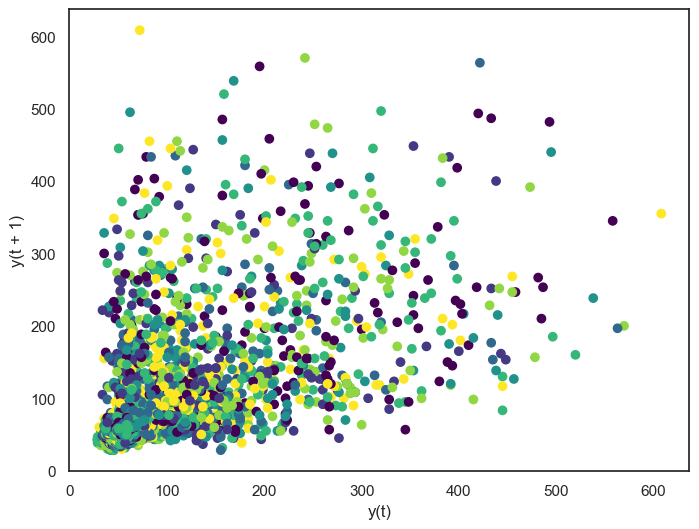

In [51]:
lag_plot(edata2['appl'],c=edata2['dayofweek'][:-1], cmap='viridis');
#where monday=0, sunday=6

## checking for uncertainity within the temperature outside

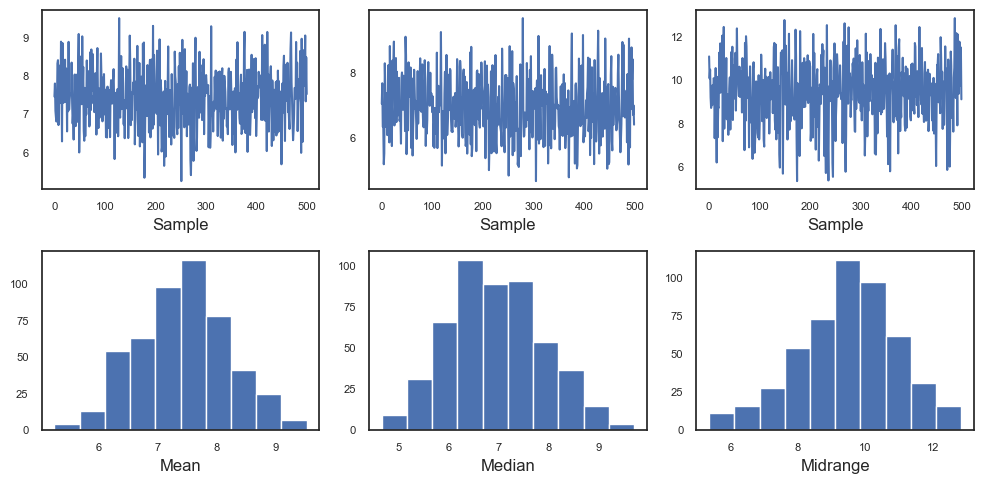

In [52]:
from pandas.plotting import bootstrap_plot
fig= bootstrap_plot(edata2.temp_out, fig=plt.figure(figsize=(10,5)))

In [ ]:
edata['weekday']= pd.Categorical(edata.date.dt.strftime('%A'), categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

In [ ]:
edata[['appl','hour']].groupby('hour').mean().plot()

In [ ]:
edata[['appl','weekday']].groupby('weekday').mean().plot()

In [ ]:
fig= px.line(edata.reset_index(), x='date', y='appl', title='energy appliance usage')

fig.update_xaxes(rangeslider_visible=True,
                )
fig.show()

## Performing 7 days moving average on the dependent variable

In [53]:
edata3=edata[['date', 'appl', 'lgt',  'temp1', 'rh_1', 'temp2', 'rh_2', 'temp3',
       'rh_3', 'temp4', 'rh_4', 'temp5', 'rh_5', 'temp6', 'rh_6', 'temp7',
       'rh_7', 'temp8', 'rh_8', 'temp9', 'rh_9', 'temp_out', 'press', 'rh_out',
       'windspeed', 'visibility', 'dewpoint', 'hour', 'dayofweek', 'month',
       'year', 'weekofyear']]

In [54]:
#edata3= edata3.set_index('date').resample('D').mean().reset_index()

In [55]:
edata3.set_index('date', inplace=True)

Text(0, 0.5, 'Appl(wH)')

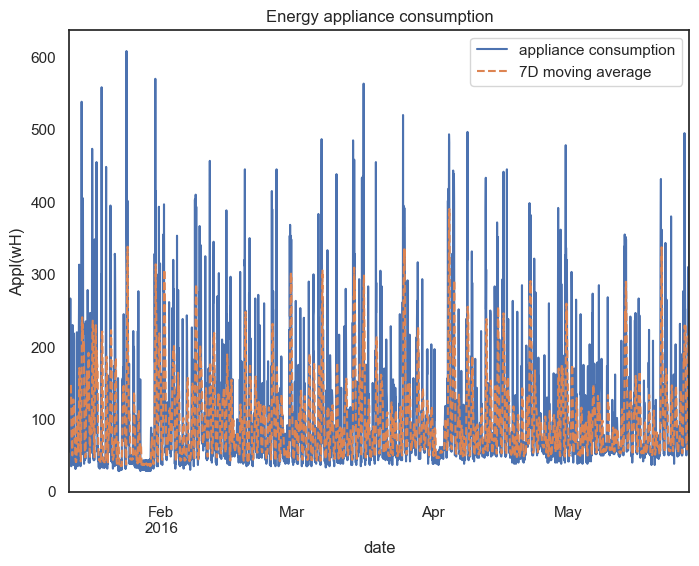

In [56]:
edata3.assign(ma=lambda x: x.appl.rolling(7).mean() #ordinary moving average
            ).plot(y=['appl','ma'],
                  title='Energy appliance consumption',
                  label=['appliance consumption', '7D moving average'],
                  style=['-', '--'])
plt.legend(loc='upper right')
plt.ylabel('Appl(wH)')

<AxesSubplot:xlabel='date'>

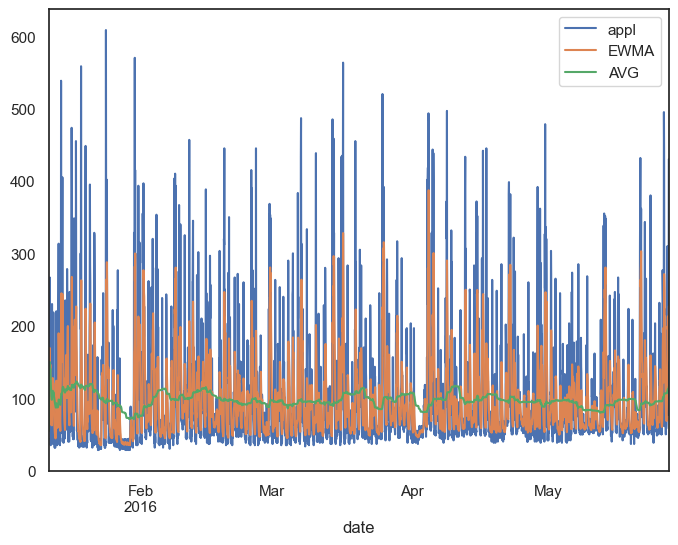

In [57]:
edata3.assign(AVG=lambda x:x.appl.rolling('7D').mean(), #performing exponentially weighted moving windows
            EWMA=lambda x:x.appl.ewm(span= 7).mean()).loc['2016-01-11' : '2016-05-27', ['appl', 'EWMA', 'AVG']].plot()

#edata.assign(AVG=lambda x:x.appl.rolling('7D').mean(), #performing exponentially weighted moving windows
            #EWMA=lambda x:x.appl.ewm(span=7).mean()).loc['2016-01-11' : '2016-05-27', ['appl', 'EWMA', 'AVG']].T

In [58]:
edata.columns

Index(['date', 'appl', 'lgt', 'temp1', 'rh_1', 'temp2', 'rh_2', 'temp3',
       'rh_3', 'temp4', 'rh_4', 'temp5', 'rh_5', 'temp6', 'rh_6', 'temp7',
       'rh_7', 'temp8', 'rh_8', 'temp9', 'rh_9', 'temp_out', 'press', 'rh_out',
       'windspeed', 'visibility', 'dewpoint', 'hour', 'dayofweek', 'month',
       'year', 'weekofyear'],
      dtype='object')

# Forecasting using Facebook Prophet (Multivariate)

In [59]:
ed_fm= edata.reset_index()[['date','appl','lgt','temp1','rh_1','temp2','rh_2','temp3','rh_3','temp4','rh_4','temp5','rh_5','temp6','rh_6','temp7','rh_7','temp8','rh_8','temp9',
                             'rh_9','temp_out','press','rh_out','windspeed','visibility','dewpoint','hour', 'dayofweek', 'month','year', 'weekofyear']].rename({'date':'ds','appl':'y',
                             'lgt':'lgt','temp1':'temp1','rh_1':'rh_1','temp2':'temp2','rh_2':'rh_2','temp3':'temp3','rh_3':'rh_3','temp4':'temp4','rh_4':'rh_4','temp5':'temp5','rh_5':'rh_5',
                             'temp6':'temp6','rh_6':'rh_6','temp7':'temp7','rh_7':'rh_7','temp8':'temp8','rh_8':'rh_8','temp9':'temp9','rh_9':'rh_9','temp_out':'temp_out','press':'press','rh_out':'rh_out',
                             'windspeed':'windspeed','visibility':'visibility','dewpoint':'dewpoint', 'hour':'hour', 'dayofweek':'dayofweek', 'month':'month', 'year':'year', 'weekofyear':'weekofyear' }, axis='columns')

In [60]:
ed_fm.head()

ds           y        lgt      temp1       rh_1      temp2  \
0 2016-01-11 17:00:00   55.000000  35.000000  19.890000  46.502778  19.200000   
1 2016-01-11 18:00:00  176.666667  51.666667  19.897778  45.879028  19.268889   
2 2016-01-11 19:00:00  173.333333  25.000000  20.495556  52.805556  19.925556   
3 2016-01-11 20:00:00  125.000000  35.000000  20.961111  48.453333  20.251111   
4 2016-01-11 21:00:00  103.333333  23.333333  21.311667  45.768333  20.587778   

        rh_2      temp3       rh_3      temp4  ...       press     rh_out  \
0  44.626528  19.790000  44.897778  18.932778  ...  733.750000  92.000000   
1  44.438889  19.770000  44.863333  18.908333  ...  734.266667  91.583333   
2  46.061667  20.052222  47.227361  18.969444  ...  734.791667  89.750000   
3  45.632639  20.213889  47.268889  19.190833  ...  735.283333  87.583333   
4  44.961111  20.373333  46.164444  19.425556  ...  735.566667  87.416667   

   windspeed  visibility  dewpoint  hour  dayofweek  month    year  weekofyear  
0   6.166667   53.416667  5.050000  17.0        0.0    1.0  2016.0         2.0  
1   5.416667   40.000000  4.658333  18.0        0.0    1.0  2016.0         2.0  
2   6.000000   40.000000  4.391667  19.0        0.0    1.0  2016.0         2.0  
3   6.000000   40.000000  4.016667  20.0        0.0    1.0  2016.0         2.0  
4   6.000000   40.000000  3.816667  21.0        0.0    1.0  2016.0         2.0  

[5 rows x 32 columns]

## Performing feature Selection using Factor Analysis

In [61]:
ed_factor= edata.reset_index()[['date','appl','lgt','temp1','rh_1','temp2','rh_2','temp3','rh_3','temp4','rh_4','temp5','rh_5','temp6','rh_6','temp7','rh_7','temp8','rh_8','temp9',
                             'rh_9','temp_out','press','rh_out','windspeed','visibility','dewpoint','hour', 'dayofweek', 'month','year', 'weekofyear']].rename({'date':'ds','appl':'y',
                             'lgt':'lgt','temp1':'temp1','rh_1':'rh_1','temp2':'temp2','rh_2':'rh_2','temp3':'temp3','rh_3':'rh_3','temp4':'temp4','rh_4':'rh_4','temp5':'temp5','rh_5':'rh_5',
                             'temp6':'temp6','rh_6':'rh_6','temp7':'temp7','rh_7':'rh_7','temp8':'temp8','rh_8':'rh_8','temp9':'temp9','rh_9':'rh_9','temp_out':'temp_out','press':'press','rh_out':'rh_out',
                             'windspeed':'windspeed','visibility':'visibility','dewpoint':'dewpoint', 'hour':'hour', 'dayofweek':'dayofweek', 'month':'month', 'year':'year', 'weekofyear':'weekofyear' }, axis='columns')

In [62]:
ed_factor.shape

(3290, 32)

In [63]:
ed_factor.drop(['ds', 'y', 'year'], axis=1, inplace=True)
#edata_p=edata_p.iloc[0:,1:27]

In [64]:
#pip install factor_analyzer

In [65]:
from factor_analyzer import FactorAnalyzer

In [66]:
#Using Bartlett's test of sphericity
#from factor_analyzer.factor_analyzer import calculate_bartlett_sphericitychi2,p = calculate_bartlett_sphericity(edata_p)
#print("Chi squared value : ",chi2)
#print("p value : ",p)#OUTPUT:Bartlett Sphericity TestChi squared value : 4054.19037041082
#p value : 0.0
#https://www.analyticsvidhya.com/blog/2020/10/dimensionality-reduction-using-factor-analysis-in-python/

In [67]:
from factor_analyzer.factor_analyzer import calculate_kmo

In [68]:
kmo_all, kmo_model = calculate_kmo(ed_factor)

In [69]:
kmo_model#OUTPUT:

0.8737987565183392

In [70]:
fa= FactorAnalyzer(n_factors=15, rotation='varimax')

In [71]:
fa.fit(ed_factor)

FactorAnalyzer(n_factors=15, rotation='varimax', rotation_kwargs={})

In [72]:
print(pd.DataFrame(fa.loadings_, index=ed_factor.columns))

                  0         1         2         3         4         5   \
lgt        -0.110095  0.077536 -0.056204  0.519020  0.010434  0.011159   
temp1       0.926288  0.093858  0.069968  0.149292  0.020671  0.161664   
rh_1        0.116668  0.914901  0.038215  0.154404  0.093603 -0.075301   
temp2       0.738600  0.186580  0.320284  0.179708 -0.004264  0.519611   
rh_2        0.030542  0.796018 -0.264432 -0.013123  0.100270 -0.483245   
temp3       0.925745  0.151583  0.055502 -0.029487  0.049749  0.024668   
rh_3       -0.170173  0.922267  0.047628  0.097505  0.060482  0.083065   
temp4       0.926594 -0.011570  0.034149  0.063013 -0.030315  0.127100   
rh_4       -0.023243  0.957387  0.095395  0.118736  0.048348  0.033633   
temp5       0.943244  0.099641  0.008386 -0.004464  0.037138  0.003934   
rh_5       -0.092224  0.348591 -0.060696  0.196370  0.047257  0.014110   
temp6       0.669828  0.216359  0.552660  0.069218 -0.009245  0.135405   
rh_6       -0.733099  0.414378 -0.3532

In [73]:
fa= FactorAnalyzer(n_factors=10, rotation='varimax')
fa.fit(ed_factor)

FactorAnalyzer(n_factors=10, rotation='varimax', rotation_kwargs={})

In [74]:
print(pd.DataFrame(fa.loadings_, index=ed_factor.columns))

                   0         1         2         3         4         5  \
lgt        -0.104411  0.074754 -0.031735  0.467949  0.022924 -0.030659   
temp1       0.926662  0.089125  0.073998  0.143097  0.021774 -0.131755   
rh_1        0.107716  0.922562  0.014708  0.165037  0.087421  0.038071   
temp2       0.741991  0.179875  0.319338  0.192244 -0.010653 -0.005028   
rh_2        0.022644  0.809175 -0.279959 -0.011259  0.101676  0.023419   
temp3       0.925510  0.151878  0.046654 -0.025226  0.050229  0.002674   
rh_3       -0.171120  0.920246  0.051863  0.090296  0.056318 -0.120768   
temp4       0.931441 -0.014314  0.060901  0.033884 -0.032523  0.007589   
rh_4       -0.024780  0.956076  0.105973  0.118687  0.050537  0.023452   
temp5       0.939650  0.107972 -0.007521  0.015734  0.034865 -0.008529   
rh_5       -0.091219  0.351817 -0.070665  0.200383  0.046255 -0.035404   
temp6       0.668103  0.213585  0.560512  0.088460 -0.022003  0.306149   
rh_6       -0.729317  0.415765 -0.3217

In [75]:
loadings= fa.loadings_

In [76]:
#estimating the eigenvalues and eigenvectors
#ev for eigenvalues
#v for eigenvectors
ev,v=fa.get_eigenvalues()

In [77]:
#performing a sreeplot
xvals= range(1, ed_factor.shape[1]+1)

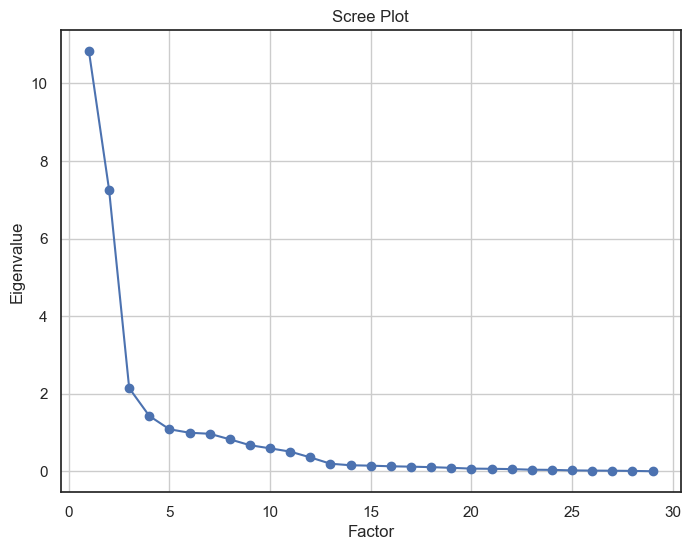

In [78]:
plt.scatter(xvals, ev)
plt.plot(xvals, ev)
plt.title('Scree Plot')
plt.xlabel('Factor')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [79]:
#print(pd.DataFrame.from_records(loadings))

In [80]:
print(pd.DataFrame(fa.get_factor_variance(),index=['Variance','Proportional Var','Cumulative Var']))

                          0         1         2         3         4         5  \
Variance          10.199865  7.045489  1.858403  1.119452  1.036098  0.618578   
Proportional Var   0.351719  0.242948  0.064083  0.038602  0.035728  0.021330   
Cumulative Var     0.351719  0.594667  0.658750  0.697352  0.733080  0.754410   

                         6         7         8         9  
Variance          0.582881  0.438100  0.386548  0.360496  
Proportional Var  0.020099  0.015107  0.013329  0.012431  
Cumulative Var    0.774509  0.789616  0.802945  0.815376  


In [81]:
print(pd.DataFrame(fa.get_communalities(),index=ed_factor.columns,columns=['Communalities']))

            Communalities
lgt              0.352484
temp1            0.943835
rh_1             0.957254
temp2            0.996662
rh_2             0.955949
temp3            0.892716
rh_3             0.927655
temp4            0.931196
rh_4             0.947366
temp5            0.912200
rh_5             0.397164
temp6            0.964656
rh_6             0.915052
temp7            0.921584
rh_7             0.891287
temp8            0.879565
rh_8             0.925088
temp9            0.972449
rh_9             0.888590
temp_out         0.987333
press            0.995334
rh_out           0.995411
windspeed        0.354220
visibility       0.025669
dewpoint         0.988693
hour             0.636732
dayofweek        0.153659
month            0.958460
weekofyear       0.977650


In [82]:
ed_fs=ed_fm[['ds', 'y', 'temp9','rh_4','hour','temp6','dewpoint','rh_5', 'dayofweek', 'visibility']] 
ed_fs.head()

ds           y      temp9       rh_4  hour     temp6  \
0 2016-01-11 17:00:00   55.000000  17.016667  45.738750  17.0  6.586667   
1 2016-01-11 18:00:00  176.666667  16.981667  46.066667  18.0  6.180000   
2 2016-01-11 19:00:00  173.333333  16.902222  47.815556  19.0  5.857361   
3 2016-01-11 20:00:00  125.000000  16.890000  49.227917  20.0  5.469444   
4 2016-01-11 21:00:00  103.333333  16.890000  47.918889  21.0  5.578889   

   dewpoint       rh_5  dayofweek  visibility  
0  5.050000  55.116667        0.0   53.416667  
1  4.658333  54.977778        0.0   40.000000  
2  4.391667  55.869861        0.0   40.000000  
3  4.016667  74.027778        0.0   40.000000  
4  3.816667  69.037778        0.0   40.000000

In [83]:
#ed_fs= ed_fs.set_index('ds').resample('D').mean().reset_index()

In [84]:
ed_fs.shape

(3290, 10)

In [85]:
ed_fs.head()

ds           y      temp9       rh_4  hour     temp6  \
0 2016-01-11 17:00:00   55.000000  17.016667  45.738750  17.0  6.586667   
1 2016-01-11 18:00:00  176.666667  16.981667  46.066667  18.0  6.180000   
2 2016-01-11 19:00:00  173.333333  16.902222  47.815556  19.0  5.857361   
3 2016-01-11 20:00:00  125.000000  16.890000  49.227917  20.0  5.469444   
4 2016-01-11 21:00:00  103.333333  16.890000  47.918889  21.0  5.578889   

   dewpoint       rh_5  dayofweek  visibility  
0  5.050000  55.116667        0.0   53.416667  
1  4.658333  54.977778        0.0   40.000000  
2  4.391667  55.869861        0.0   40.000000  
3  4.016667  74.027778        0.0   40.000000  
4  3.816667  69.037778        0.0   40.000000

In [86]:
#edata_final['y_origi']= np.log(edata_final['y'])
e_train= ed_fs[(ed_fs['ds'] >= '2016-01-11') & (ed_fs['ds'] <= '2016-04-16')]
e_test= ed_fs[(ed_fs['ds'] >'2016-04-16')]


In [87]:
e_train.shape

(2288, 10)

In [88]:
e_test.shape

(1002, 10)

In [89]:
e_train

ds           y      temp9       rh_4  hour      temp6  \
0    2016-01-11 17:00:00   55.000000  17.016667  45.738750  17.0   6.586667   
1    2016-01-11 18:00:00  176.666667  16.981667  46.066667  18.0   6.180000   
2    2016-01-11 19:00:00  173.333333  16.902222  47.815556  19.0   5.857361   
3    2016-01-11 20:00:00  125.000000  16.890000  49.227917  20.0   5.469444   
4    2016-01-11 21:00:00  103.333333  16.890000  47.918889  21.0   5.578889   
...                  ...         ...        ...        ...   ...        ...   
2283 2016-04-15 20:00:00  110.000000  20.878889  40.670185  20.0  11.823889   
2284 2016-04-15 21:00:00  103.333333  20.856667  40.682037  21.0  10.842500   
2285 2016-04-15 22:00:00   81.666667  20.878889  40.678981  22.0  10.141111   
2286 2016-04-15 23:00:00   56.666667  20.833056  40.459907  23.0  10.477778   
2287 2016-04-16 00:00:00   53.333333  20.851111  40.200000   0.0  10.336250   

      dewpoint       rh_5  dayofweek  visibility  
0     5.050000  55.116667        0.0   53.416667  
1     4.658333  54.977778        0.0   40.000000  
2     4.391667  55.869861        0.0   40.000000  
3     4.016667  74.027778        0.0   40.000000  
4     3.816667  69.037778        0.0   40.000000  
...        ...        ...        ...         ...  
2283  8.116667  71.825556        4.0   35.416667  
2284  8.658333  59.330000        4.0   33.583333  
2285  8.141667  54.974444        4.0   40.000000  
2286  7.541667  53.385556        4.0   40.000000  
2287  7.225000  52.861528        5.0   40.000000  

[2288 rows x 10 columns]

In [90]:
m= Prophet(interval_width=0.95, changepoint_prior_scale=0.5)
#m= Prophet(interval_width=0.95, changepoint_prior_scale=0.5, weekly_seasonality=True, yearly_seasonality=False, daily_seasonality=True)
#m.add_seasonality(name='weekly', period=7, fourier_order=3)
#m= Prophet()

In [91]:
e_train.columns

Index(['ds', 'y', 'temp9', 'rh_4', 'hour', 'temp6', 'dewpoint', 'rh_5',
       'dayofweek', 'visibility'],
      dtype='object')

In [92]:
#m.add_regressor('year', standardize=False)
m.add_regressor('temp9')
m.add_regressor('rh_4')   
m.add_regressor('temp6')
m.add_regressor('dewpoint')
m.add_regressor('rh_5')
m.add_regressor('dayofweek', standardize=False)
m.add_regressor('hour', standardize=False)
m.add_regressor('visibility')
#m.add_regressor('weekofyear', standardize=False)
#m.add_regressor('month_temp', standardize=False)
#m.add_regressor('month_bins', standardize=False, mode='multiplicative')


In [93]:
m.fit(e_train)

13:15:44 - cmdstanpy - INFO - Chain [1] start processing
13:15:44 - cmdstanpy - INFO - Chain [1] done processing


In [94]:
m.params # printing parameters

OrderedDict([('lp__', array([[3703.89]])),
             ('k', array([[-0.193671]])),
             ('m', array([[0.183714]])),
             ('delta',
              array([[-2.10708e-01, -3.39286e-06,  2.16388e-04,  1.16155e-01,
                       6.96537e-01,  4.25331e-06, -2.27755e-01, -5.71625e-04,
                      -9.14958e-02, -1.64792e-01, -5.77561e-05,  8.53204e-04,
                      -1.41466e-03,  1.41052e-01, -1.14823e-03,  1.36891e-05,
                       6.16895e-02,  4.55395e-02,  2.45101e-02, -1.20279e-05,
                      -2.77490e-01,  2.19597e-04,  1.61676e-02, -3.48714e-04,
                       1.53640e-01]])),
             ('sigma_obs', array([[0.1199]])),
             ('beta',
              array([[ 0.00383363, -0.0173684 ,  0.00542446,  0.00062236, -0.00247495,
                       0.00691213, -0.0620832 , -0.0621884 , -0.0180971 , -0.0172464 ,
                       0.0326406 , -0.0110548 ,  0.00825166,  0.0121069 ,  0.00017474,
             

In [95]:
future = m.make_future_dataframe(periods= 1002, freq='H') # 
future.tail()

ds
3285 2016-05-27 14:00:00
3286 2016-05-27 15:00:00
3287 2016-05-27 16:00:00
3288 2016-05-27 17:00:00
3289 2016-05-27 18:00:00

In [96]:
future['temp9']= ed_fs['temp9']
future['rh_4']= ed_fs['rh_4']
future['temp6']= ed_fs['temp6']
future['hour']= ed_fs['hour']
future['dewpoint']= ed_fs['dewpoint']
future['rh_5']= ed_fs['rh_5']
future['dayofweek']= ed_fs['dayofweek']
future['visibility']= ed_fs['visibility']

In [97]:
future

ds      temp9       rh_4      temp6  hour   dewpoint  \
0    2016-01-11 17:00:00  17.016667  45.738750   6.586667  17.0   5.050000   
1    2016-01-11 18:00:00  16.981667  46.066667   6.180000  18.0   4.658333   
2    2016-01-11 19:00:00  16.902222  47.815556   5.857361  19.0   4.391667   
3    2016-01-11 20:00:00  16.890000  49.227917   5.469444  20.0   4.016667   
4    2016-01-11 21:00:00  16.890000  47.918889   5.578889  21.0   3.816667   
...                  ...        ...        ...        ...   ...        ...   
3285 2016-05-27 14:00:00  23.100000  45.883889  25.567222  14.0  13.483333   
3286 2016-05-27 15:00:00  23.138889  45.270000  26.279444  15.0  13.266667   
3287 2016-05-27 16:00:00  23.193333  45.476667  26.138889  16.0  13.283333   
3288 2016-05-27 17:00:00  23.200000  45.658889  24.441111  17.0  13.316667   
3289 2016-05-27 18:00:00  23.200000  45.963333  21.026667  18.0  13.200000   

           rh_5  dayofweek  visibility  
0     55.116667        0.0   53.416667  
1     54.977778        0.0   40.000000  
2     55.869861        0.0   40.000000  
3     74.027778        0.0   40.000000  
4     69.037778        0.0   40.000000  
...         ...        ...         ...  
3285  53.052222        4.0   21.583333  
3286  52.368611        4.0   21.833333  
3287  52.094444        4.0   22.583333  
3288  52.296667        4.0   24.083333  
3289  52.200000        4.0   27.000000  

[3290 rows x 9 columns]

In [98]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
3285 2016-05-27 14:00:00  127.714907  -59.753010  316.054494
3286 2016-05-27 15:00:00  125.096258  -60.425563  314.315759
3287 2016-05-27 16:00:00  143.099235  -44.825134  342.176220
3288 2016-05-27 17:00:00  173.428551  -17.273315  368.526907
3289 2016-05-27 18:00:00  197.979511   10.577536  392.559521

In [99]:
from sklearn.metrics import r2_score
print('r2:', r2_score(ed_fs['y'], forecast['yhat']))

r2: 0.23219417442728663


In [100]:
forecast

ds       trend  yhat_lower  yhat_upper  trend_lower  \
0    2016-01-11 17:00:00  111.759350   52.031214  342.255883   111.759350   
1    2016-01-11 18:00:00  111.707834   77.218603  354.162213   111.707834   
2    2016-01-11 19:00:00  111.656318   72.342548  356.660959   111.656318   
3    2016-01-11 20:00:00  111.604803   49.351268  329.359174   111.604803   
4    2016-01-11 21:00:00  111.553287    7.999955  280.934425   111.553287   
...                  ...         ...         ...         ...          ...   
3285 2016-05-27 14:00:00  142.431607  -59.753010  316.054494    25.623829   
3286 2016-05-27 15:00:00  142.454783  -60.425563  314.315759    25.575374   
3287 2016-05-27 16:00:00  142.477959  -44.825134  342.176220    25.526919   
3288 2016-05-27 17:00:00  142.501135  -17.273315  368.526907    25.478465   
3289 2016-05-27 18:00:00  142.524311   10.577536  392.559521    25.430010   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0      111.759350       87.075552             87.075552             87.075552   
1      111.707834      103.952443            103.952443            103.952443   
2      111.656318      100.190729            100.190729            100.190729   
3      111.604803       76.932161             76.932161             76.932161   
4      111.553287       30.686626             30.686626             30.686626   
...           ...             ...                   ...                   ...   
3285   272.884186      -14.716699            -14.716699            -14.716699   
3286   273.166736      -17.358525            -17.358525            -17.358525   
3287   273.449286        0.621276              0.621276              0.621276   
3288   273.731835       30.927416             30.927416             30.927416   
3289   274.014385       55.455200             55.455200             55.455200   

          daily  ...  visibility  visibility_lower  visibility_upper  \
0     58.473820  ...    1.234244          1.234244          1.234244   
1     75.480236  ...    0.090953          0.090953          0.090953   
2     68.105049  ...    0.090953          0.090953          0.090953   
3     35.961427  ...    0.090953          0.090953          0.090953   
4     -5.686489  ...    0.090953          0.090953          0.090953   
...         ...  ...         ...               ...               ...   
3285  17.674932  ...   -1.478409         -1.478409         -1.478409   
3286  16.286286  ...   -1.457105         -1.457105         -1.457105   
3287  32.579950  ...   -1.393195         -1.393195         -1.393195   
3288  58.473820  ...   -1.265373         -1.265373         -1.265373   
3289  75.480236  ...   -1.016832         -1.016832         -1.016832   

        weekly  weekly_lower  weekly_upper  multiplicative_terms  \
0     9.398270      9.398270      9.398270                   0.0   
1     8.591471      8.591471      8.591471                   0.0   
2     7.720750      7.720750      7.720750                   0.0   
3     6.791364      6.791364      6.791364                   0.0   
4     5.809189      5.809189      5.809189                   0.0   
...        ...           ...           ...                   ...   
3285  0.874271      0.874271      0.874271                   0.0   
3286  1.531976      1.531976      1.531976                   0.0   
3287  2.185645      2.185645      2.185645                   0.0   
3288  2.829816      2.829816      2.829816                   0.0   
3289  3.459119      3.459119      3.459119                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                            0.0                         0.0  198.834902  
1                            0.0                         0.0  215.660277  
2                            0.0                         0.0  211.847048  
3                            0.0                         0.0  188.536964  
4                            0.0                         0.0  142.2

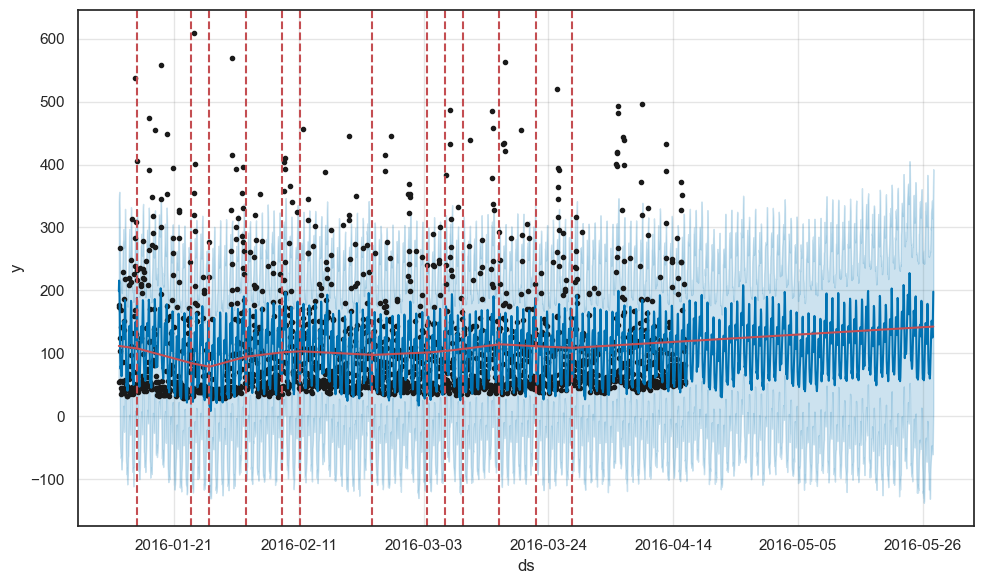

In [101]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [102]:
print(m.params['delta'])

[[-2.10708e-01 -3.39286e-06  2.16388e-04  1.16155e-01  6.96537e-01
   4.25331e-06 -2.27755e-01 -5.71625e-04 -9.14958e-02 -1.64792e-01
  -5.77561e-05  8.53204e-04 -1.41466e-03  1.41052e-01 -1.14823e-03
   1.36891e-05  6.16895e-02  4.55395e-02  2.45101e-02 -1.20279e-05
  -2.77490e-01  2.19597e-04  1.61676e-02 -3.48714e-04  1.53640e-01]]


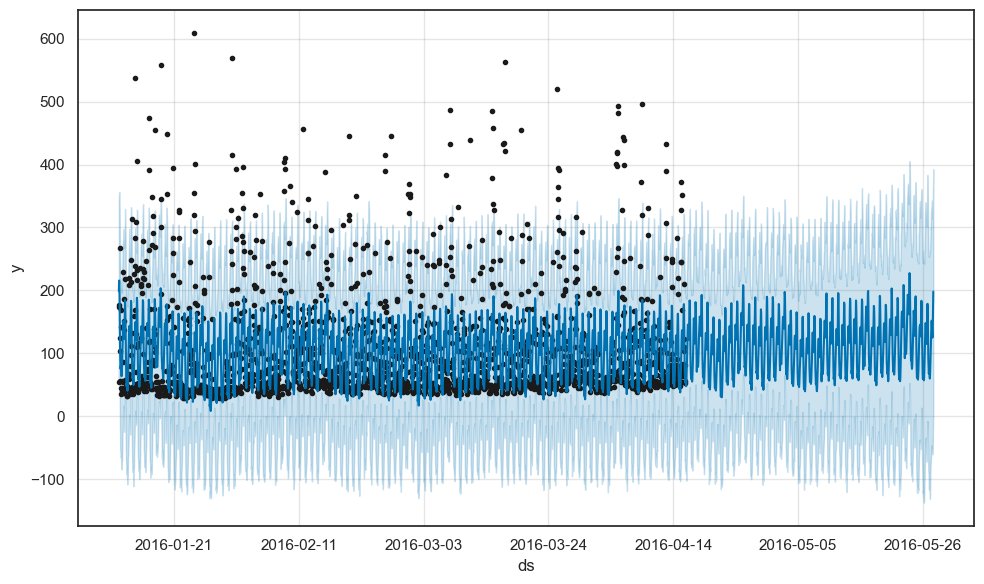

In [103]:
fig1= m.plot(forecast)

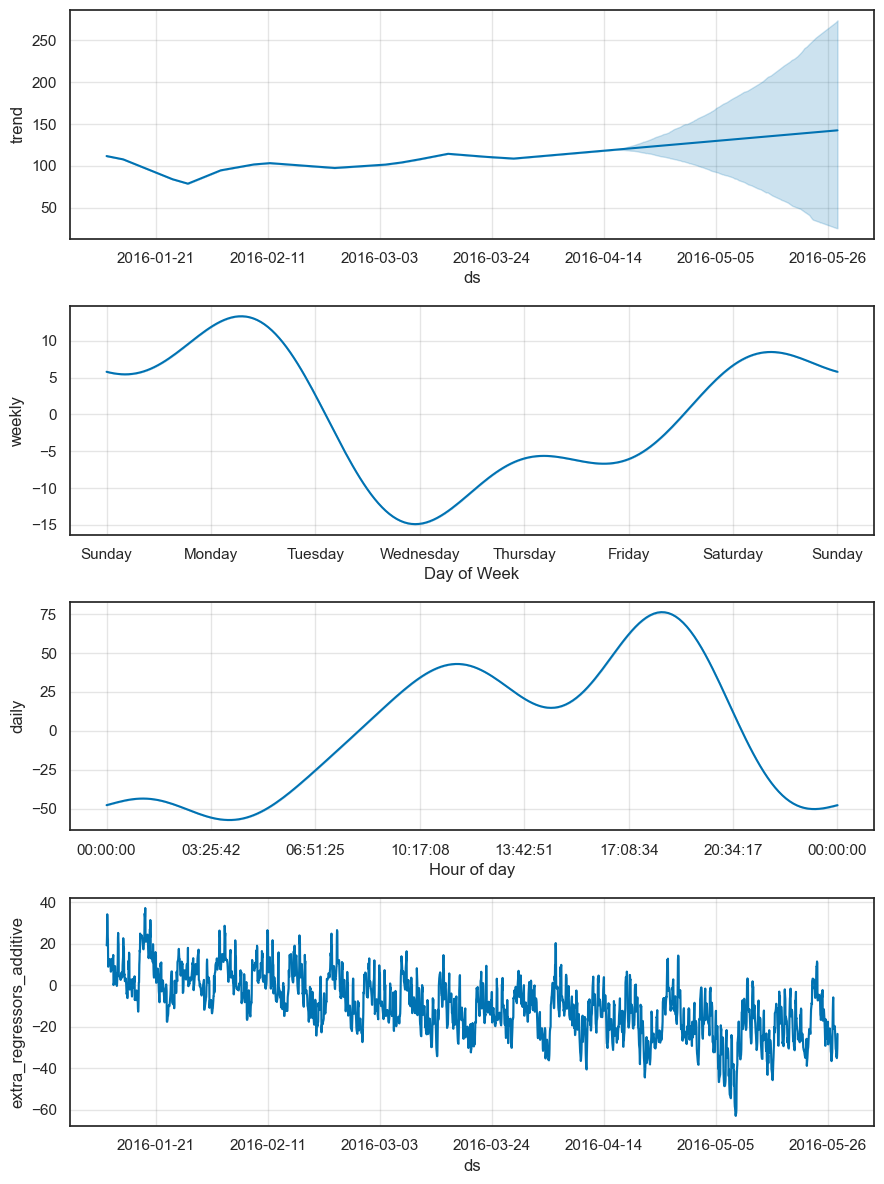

In [104]:
fig2= m.plot_components(forecast)

In [105]:
from prophet.utilities import regressor_coefficients
regressor_coefficients(m)
# the mean value of the prestandardised regressor (raw values) are displayed on the center column and if the regressor not standardised it is displayed as 0
#the coef column is the most important column because it shows the expected value i.e expected impact on y of a unit increased in the regressor
# the coefficent of temp9 is 0.54 that means that for eevry degree higher than the center 18.59 , the expected effect on ridership will be 0.54 or 54% increase

regressor regressor_mode     center  coef_lower      coef  coef_upper
0       temp9       additive  18.579274    0.075505  0.075505    0.075505
1        rh_4       additive  39.460754    1.766530  1.766530    1.766530
2       temp6       additive   5.927540   -1.647736 -1.647736   -1.647736
3    dewpoint       additive   2.731190   -0.394006 -0.394006   -0.394006
4        rh_5       additive  51.897878    0.334152  0.334152    0.334152
5   dayofweek       additive   0.000000   -3.446756 -3.446756   -3.446756
6        hour       additive   0.000000    0.465945  0.465945    0.465945
7  visibility       additive  38.932656    0.085214  0.085214    0.085214

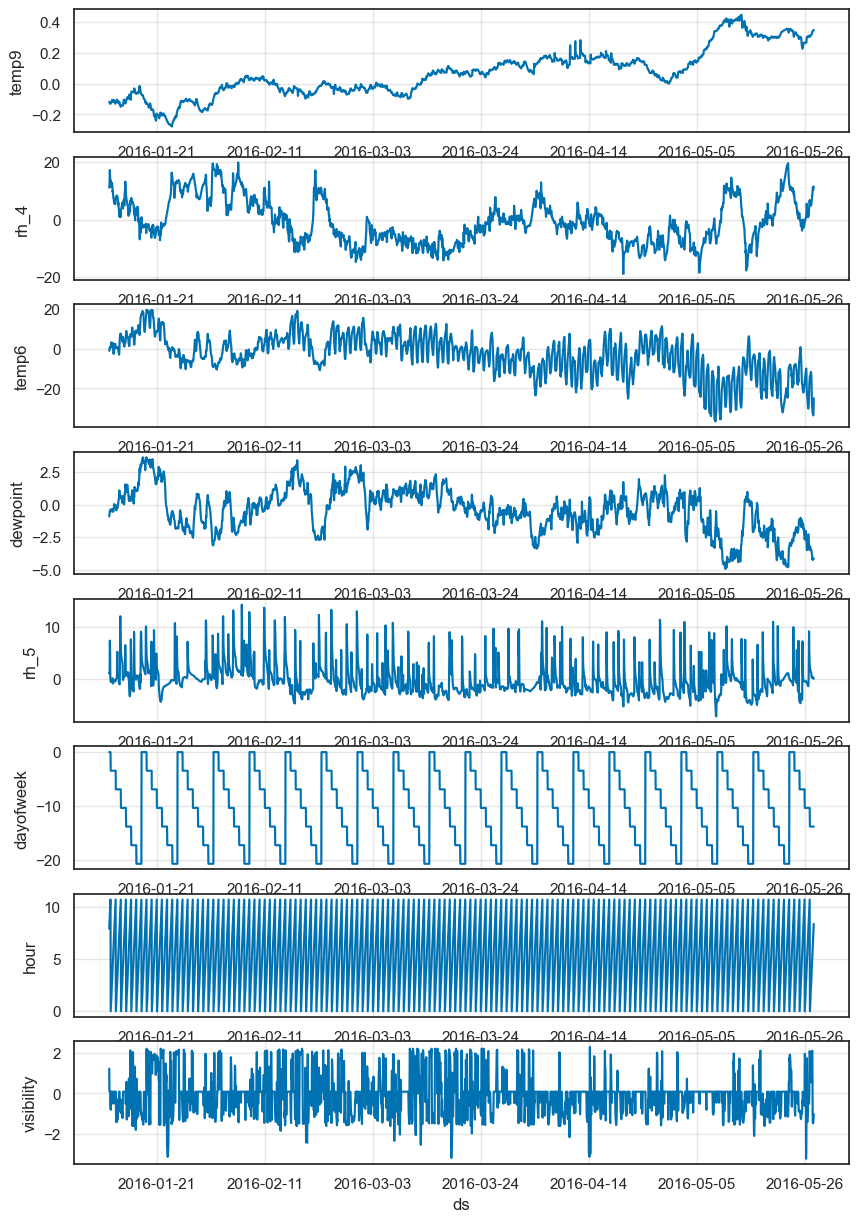

In [106]:
from prophet.plot import plot_forecast_component 
fig, axes= plt.subplots(len(regressor_coefficients(m)), figsize=(10,15))
for i, regressor in enumerate(regressor_coefficients(m)['regressor']):
    plot_forecast_component(m, forecast, regressor, axes[i])

plt.show()

In [107]:
from prophet.diagnostics import cross_validation, performance_metrics

cv_r = cross_validation(m, horizon='41 days', period='30 days', initial= '50 days')
df_p= performance_metrics(cv_r)
df_p

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]13:16:55 - cmdstanpy - INFO - Chain [1] start processing
13:16:56 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.06s/it]


horizon          mse       rmse        mae      mape     mdape  \
0    4 days 02:00:00  5084.838672  71.308055  48.133814  0.579876  0.438452   
1    4 days 03:00:00  5083.842332  71.301068  48.085071  0.579037  0.438452   
2    4 days 04:00:00  5081.328891  71.283441  47.970256  0.576281  0.438452   
3    4 days 05:00:00  5080.239054  71.275796  47.894647  0.574237  0.438452   
4    4 days 06:00:00  5090.836740  71.350100  48.188759  0.582930  0.447643   
..               ...          ...        ...        ...       ...       ...   
882 40 days 20:00:00  9232.905564  96.088009  60.083982  0.528013  0.519283   
883 40 days 21:00:00  9247.607170  96.164480  60.296781  0.530432  0.519283   
884 40 days 22:00:00  9278.978838  96.327456  60.725984  0.536142  0.522018   
885 40 days 23:00:00  9302.445472  96.449186  61.137487  0.543745  0.524109   
886 41 days 00:00:00  9332.102992  96.602810  61.554927  0.551962  0.526614   

        smape  coverage  
0    0.440198   0.94898  
1    0.439523   0.94898  
2    0.437362   0.94898  
3    0.435626   0.94898  
4    0.441297   0.94898  
..        ...       ...  
882  0.784265   1.00000  
883  0.788100   1.00000  
884  0.797828   1.00000  
885  0.812093   1.00000  
886  0.829660   1.00000  

[887 rows x 8 columns]

In [108]:
df_p.head()

horizon          mse       rmse        mae      mape     mdape  \
0 4 days 02:00:00  5084.838672  71.308055  48.133814  0.579876  0.438452   
1 4 days 03:00:00  5083.842332  71.301068  48.085071  0.579037  0.438452   
2 4 days 04:00:00  5081.328891  71.283441  47.970256  0.576281  0.438452   
3 4 days 05:00:00  5080.239054  71.275796  47.894647  0.574237  0.438452   
4 4 days 06:00:00  5090.836740  71.350100  48.188759  0.582930  0.447643   

      smape  coverage  
0  0.440198   0.94898  
1  0.439523   0.94898  
2  0.437362   0.94898  
3  0.435626   0.94898  
4  0.441297   0.94898

In [109]:
df_p.mean()

horizon     22 days 13:00:00
mse              6503.717593
rmse               77.222029
mae                48.495427
mape                0.487709
mdape               0.438099
smape               0.577353
coverage            0.983158
dtype: object

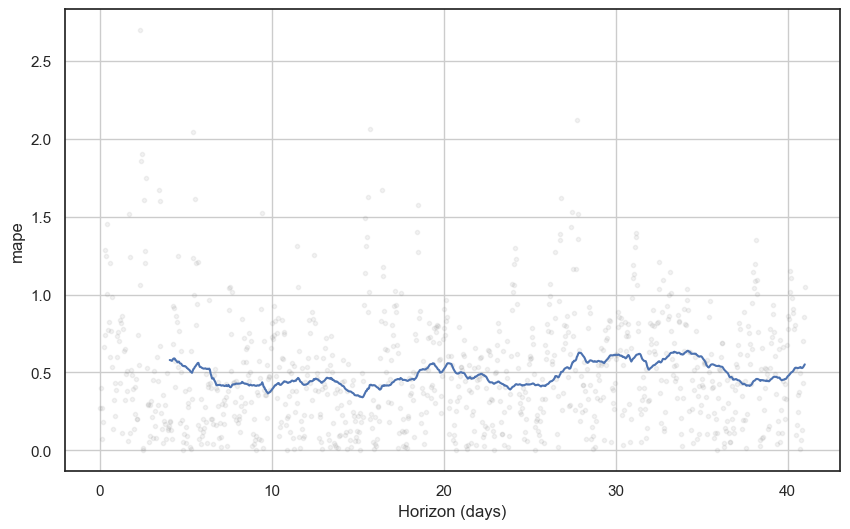

In [110]:
from prophet.plot import plot_cross_validation_metric

fig3 = plot_cross_validation_metric(cv_r, metric='mape')

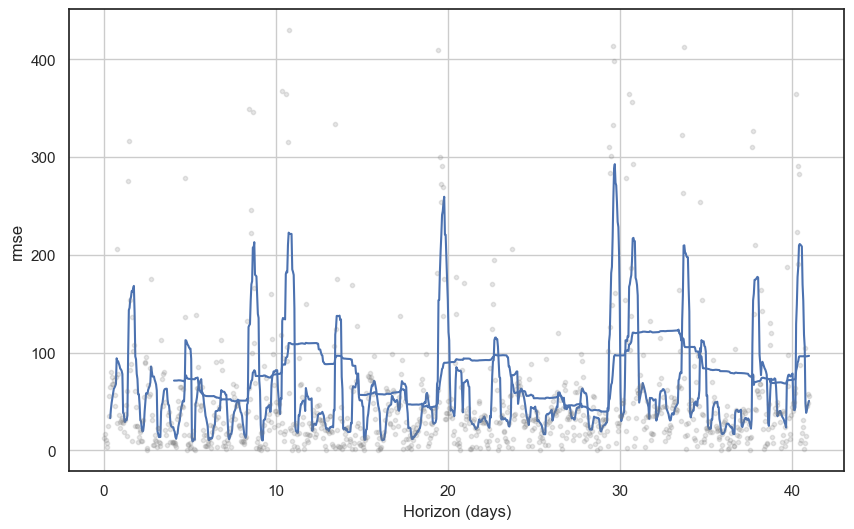

In [111]:
fig= plt.figure(figsize=(10,6))
ax= fig.add_subplot(111)
plot_cross_validation_metric(cv_r, metric='rmse', rolling_window= .01, ax=ax)

plot_cross_validation_metric(cv_r, metric='rmse', rolling_window= .1, ax=ax)

plt.show()

# Forecasting using Facebook Prophet (Multivariate) all variables

In [112]:
ed_fm= edata.reset_index()[['date','appl','lgt','temp1','rh_1','temp2','rh_2','temp3','rh_3','temp4','rh_4','temp5','rh_5','temp6','rh_6','temp7','rh_7','temp8','rh_8','temp9',
                             'rh_9','temp_out','press','rh_out','windspeed','visibility','dewpoint','hour', 'dayofweek', 'month','year', 'weekofyear']].rename({'date':'ds','appl':'y',
                             'lgt':'lgt','temp1':'temp1','rh_1':'rh_1','temp2':'temp2','rh_2':'rh_2','temp3':'temp3','rh_3':'rh_3','temp4':'temp4','rh_4':'rh_4','temp5':'temp5','rh_5':'rh_5',
                             'temp6':'temp6','rh_6':'rh_6','temp7':'temp7','rh_7':'rh_7','temp8':'temp8','rh_8':'rh_8','temp9':'temp9','rh_9':'rh_9','temp_out':'temp_out','press':'press','rh_out':'rh_out',
                             'windspeed':'windspeed','visibility':'visibility','dewpoint':'dewpoint', 'hour':'hour', 'dayofweek':'dayofweek', 'month':'month', 'year':'year', 'weekofyear':'weekofyear' }, axis='columns')

In [113]:
ed_fm

ds           y        lgt      temp1       rh_1  \
0    2016-01-11 17:00:00   55.000000  35.000000  19.890000  46.502778   
1    2016-01-11 18:00:00  176.666667  51.666667  19.897778  45.879028   
2    2016-01-11 19:00:00  173.333333  25.000000  20.495556  52.805556   
3    2016-01-11 20:00:00  125.000000  35.000000  20.961111  48.453333   
4    2016-01-11 21:00:00  103.333333  23.333333  21.311667  45.768333   
...                  ...         ...        ...        ...        ...   
3285 2016-05-27 14:00:00  101.666667   1.666667  25.544444  46.638889   
3286 2016-05-27 15:00:00   76.666667   0.000000  25.500000  45.677639   
3287 2016-05-27 16:00:00  135.000000   0.000000  25.487778  46.250000   
3288 2016-05-27 17:00:00  180.000000   3.333333  25.533333  46.783333   
3289 2016-05-27 18:00:00  430.000000  10.000000  25.500000  46.600000   

          temp2       rh_2      temp3       rh_3      temp4  ...       press  \
0     19.200000  44.626528  19.790000  44.897778  18.932778  ...  733.750000   
1     19.268889  44.438889  19.770000  44.863333  18.908333  ...  734.266667   
2     19.925556  46.061667  20.052222  47.227361  18.969444  ...  734.791667   
3     20.251111  45.632639  20.213889  47.268889  19.190833  ...  735.283333   
4     20.587778  44.961111  20.373333  46.164444  19.425556  ...  735.566667   
...         ...        ...        ...        ...        ...  ...         ...   
3285  26.421369  41.205054  28.397778  41.160000  24.666667  ...  755.800000   
3286  26.154762  41.041238  28.240000  40.306667  24.694444  ...  755.675000   
3287  26.000000  41.736190  27.953333  40.607778  24.700000  ...  755.375000   
3288  25.772190  42.495476  27.164444  41.247778  24.700000  ...  755.200000   
3289  25.264286  42.971429  26.823333  41.156667  24.700000  ...  755.200000   

         rh_out  windspeed  visibility   dewpoint  hour  dayofweek  month  \
0     92.000000   6.166667   53.416667   5.050000  17.0        0.0    1.0   
1     91.583333   5.416667   40.000000   4.658333  18.0        0.0    1.0   
2     89.750000   6.000000   40.000000   4.391667  19.0        0.0    1.0   
3     87.583333   6.000000   40.000000   4.016667  20.0        0.0    1.0   
4     87.416667   6.000000   40.000000   3.816667  21.0        0.0    1.0   
...         ...        ...         ...        ...   ...        ...    ...   
3285  59.000000   2.000000   21.583333  13.483333  14.0        4.0    5.0   
3286  57.333333   2.000000   21.833333  13.266667  15.0        4.0    5.0   
3287  55.000000   2.416667   22.583333  13.283333  16.0        4.0    5.0   
3288  55.833333   3.416667   24.083333  13.316667  17.0        4.0    5.0   
3289  57.000000   4.000000   27.000000  13.200000  18.0        4.0    5.0   

        year  weekofyear  
0     2016.0         2.0  
1     2016.0         2.0  
2     2016.0         2.0  
3     2016.0         2.0  
4     2016.0         2.0  
...      ...         ...  
3285  2016.0        21.0  
3286  2016.0        21.0  
3287  2016.0        21.0  
3288  2016.0        21.0  
3289  2016.0        21.0  

[3290 rows x 32 columns]

In [114]:
train= ed_fm[(ed_fm['ds'] >= '2016-01-11') & (ed_fm['ds'] <= '2016-04-16')]
test= ed_fm[(ed_fm['ds'] >'2016-04-16')]

In [115]:
ed_fm.shape

(3290, 32)

In [116]:
train.shape

(2288, 32)

In [117]:
test.shape

(1002, 32)

In [118]:
test

ds           y        lgt      temp1       rh_1  \
2288 2016-04-16 01:00:00   55.000000   0.000000  22.514722  41.591667   
2289 2016-04-16 02:00:00   50.000000   0.000000  22.340000  41.483333   
2290 2016-04-16 03:00:00   56.666667   0.000000  22.235000  41.500000   
2291 2016-04-16 04:00:00   48.333333   0.000000  22.105556  41.609444   
2292 2016-04-16 05:00:00   53.333333   0.000000  21.926667  41.750000   
...                  ...         ...        ...        ...        ...   
3285 2016-05-27 14:00:00  101.666667   1.666667  25.544444  46.638889   
3286 2016-05-27 15:00:00   76.666667   0.000000  25.500000  45.677639   
3287 2016-05-27 16:00:00  135.000000   0.000000  25.487778  46.250000   
3288 2016-05-27 17:00:00  180.000000   3.333333  25.533333  46.783333   
3289 2016-05-27 18:00:00  430.000000  10.000000  25.500000  46.600000   

          temp2       rh_2      temp3       rh_3      temp4  ...       press  \
2288  20.077778  44.687778  23.902222  39.433333  21.932778  ...  744.541667   
2289  19.933889  44.773333  24.000000  39.530000  21.880278  ...  744.641667   
2290  19.775556  44.857222  24.045833  39.704583  21.795556  ...  744.700000   
2291  19.666667  45.040000  24.194444  39.808333  21.760000  ...  744.783333   
2292  19.577778  45.183333  24.166667  39.887778  21.715000  ...  744.983333   
...         ...        ...        ...        ...        ...  ...         ...   
3285  26.421369  41.205054  28.397778  41.160000  24.666667  ...  755.800000   
3286  26.154762  41.041238  28.240000  40.306667  24.694444  ...  755.675000   
3287  26.000000  41.736190  27.953333  40.607778  24.700000  ...  755.375000   
3288  25.772190  42.495476  27.164444  41.247778  24.700000  ...  755.200000   
3289  25.264286  42.971429  26.823333  41.156667  24.700000  ...  755.200000   

         rh_out  windspeed  visibility   dewpoint  hour  dayofweek  month  \
2288  78.666667   6.416667   40.000000   6.783333   1.0        5.0    4.0   
2289  81.416667   7.000000   40.000000   7.025000   2.0        5.0    4.0   
2290  83.250000   6.583333   40.000000   7.116667   3.0        5.0    4.0   
2291  86.250000   5.583333   35.000000   7.125000   4.0        5.0    4.0   
2292  88.416667   5.000000   27.583333   7.425000   5.0        5.0    4.0   
...         ...        ...         ...        ...   ...        ...    ...   
3285  59.000000   2.000000   21.583333  13.483333  14.0        4.0    5.0   
3286  57.333333   2.000000   21.833333  13.266667  15.0        4.0    5.0   
3287  55.000000   2.416667   22.583333  13.283333  16.0        4.0    5.0   
3288  55.833333   3.416667   24.083333  13.316667  17.0        4.0    5.0   
3289  57.000000   4.000000   27.000000  13.200000  18.0        4.0    5.0   

        year  weekofyear  
2288  2016.0        15.0  
2289  2016.0        15.0  
2290  2016.0        15.0  
2291  2016.0        15.0  
2292  2016.0        15.0  
...      ...         ...  
3285  2016.0        21.0  
3286  2016.0        21.0  
3287  2016.0        21.0  
3288  2016.0        21.0  
3289  2016.0        21.0  

[1002 rows x 32 columns]

In [119]:
ed_fm.columns

Index(['ds', 'y', 'lgt', 'temp1', 'rh_1', 'temp2', 'rh_2', 'temp3', 'rh_3',
       'temp4', 'rh_4', 'temp5', 'rh_5', 'temp6', 'rh_6', 'temp7', 'rh_7',
       'temp8', 'rh_8', 'temp9', 'rh_9', 'temp_out', 'press', 'rh_out',
       'windspeed', 'visibility', 'dewpoint', 'hour', 'dayofweek', 'month',
       'year', 'weekofyear'],
      dtype='object')

In [120]:
#model=Prophet(interval_width=0.95, changepoint_prior_scale=0.5)
#model=Prophet(interval_width=0.95, changepoint_prior_scale=0.5, weekly_seasonality=True, yearly_seasonality=False, daily_seasonality=True)
#model.add_seasonality(name='weekly', period=30, fourier_order=3)
model= Prophet(mcmc_samples=300)

In [121]:
#m.add_regressor('year', standardize=False)
model.add_regressor('lgt')
model.add_regressor('temp1')   
model.add_regressor('rh_1')
model.add_regressor('temp2')
model.add_regressor('rh_2')
model.add_regressor('temp3')
model.add_regressor('rh_3')   
model.add_regressor('temp4')
model.add_regressor('rh_4')
model.add_regressor('temp5')
model.add_regressor('rh_5')
model.add_regressor('temp6')   
model.add_regressor('rh_6')
model.add_regressor('temp7')
model.add_regressor('rh_7')
model.add_regressor('temp8')
model.add_regressor('rh_8')   
model.add_regressor('temp9')
model.add_regressor('rh_9')
model.add_regressor('temp_out')
model.add_regressor('press')
model.add_regressor('rh_out')   
model.add_regressor('windspeed')
model.add_regressor('visibility')
model.add_regressor('dewpoint')
model.add_regressor('hour', standardize=False)
model.add_regressor('dayofweek', standardize=False)
model.add_regressor('month', standardize=False)
model.add_regressor('year', standardize=False)
model.add_regressor('weekofyear', standardize=False)

In [122]:
model.fit(train)
#model.fit(train)

13:19:04 - cmdstanpy - INFO - CmdStan installation C:\Anaconda\envs\tensorflow\lib\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
13:19:04 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
13:19:04 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                                | 00:00 Status
chain 2 |                                                                                                | 00:00 Status

chain 3 |                                                                                                | 00:00 Status


chain 4 |                                                                                                | 00:00 Status

chain 3 |███████████████████▏                                                                            | 00:00 Status
chain 1 |███████████████████▏                                                                


13:25:18 - cmdstanpy - INFO - CmdStan done processing.
13:25:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exce

In [123]:
future_data= model.make_future_dataframe(periods=1002, freq= 'H')  #1002

In [124]:
future_data.tail()

ds
3285 2016-05-27 14:00:00
3286 2016-05-27 15:00:00
3287 2016-05-27 16:00:00
3288 2016-05-27 17:00:00
3289 2016-05-27 18:00:00

In [125]:
ed_fm.columns

Index(['ds', 'y', 'lgt', 'temp1', 'rh_1', 'temp2', 'rh_2', 'temp3', 'rh_3',
       'temp4', 'rh_4', 'temp5', 'rh_5', 'temp6', 'rh_6', 'temp7', 'rh_7',
       'temp8', 'rh_8', 'temp9', 'rh_9', 'temp_out', 'press', 'rh_out',
       'windspeed', 'visibility', 'dewpoint', 'hour', 'dayofweek', 'month',
       'year', 'weekofyear'],
      dtype='object')

In [126]:
future_data['lgt']= ed_fm['lgt']
future_data['temp1']= ed_fm['temp1']
future_data['rh_1']= ed_fm['rh_1']
future_data['temp2']= ed_fm['temp2']
future_data['rh_2']= ed_fm['rh_2']
future_data['temp3']= ed_fm['temp3']
future_data['rh_3']= ed_fm['rh_3']
future_data['temp4']= ed_fm['temp4']
future_data['rh_4']= ed_fm['rh_4']
future_data['temp5']= ed_fm['temp5']
future_data['rh_5']= ed_fm['rh_5']
future_data['temp6']= ed_fm['temp6']
future_data['rh_6']= ed_fm['rh_6']
future_data['temp7']= ed_fm['temp7']
future_data['rh_7']= ed_fm['rh_7']
future_data['temp8']= ed_fm['temp8']
future_data['rh_8']= ed_fm['rh_8']
future_data['temp9']= ed_fm['temp9']
future_data['rh_9']= ed_fm['rh_9']
future_data['temp_out']= ed_fm['temp_out']
future_data['press']= ed_fm['press']
future_data['rh_out']= ed_fm['rh_out']
future_data['windspeed']= ed_fm['windspeed']
future_data['visibility']= ed_fm['visibility']
future_data['dewpoint']= ed_fm['dewpoint']
future_data['hour']= ed_fm['hour']
future_data['dayofweek']= ed_fm['dayofweek']
future_data['month']= ed_fm['month']
future_data['year']= ed_fm['year']
future_data['weekofyear']= ed_fm['weekofyear']

In [127]:
future_data.tail()

ds        lgt      temp1       rh_1      temp2  \
3285 2016-05-27 14:00:00   1.666667  25.544444  46.638889  26.421369   
3286 2016-05-27 15:00:00   0.000000  25.500000  45.677639  26.154762   
3287 2016-05-27 16:00:00   0.000000  25.487778  46.250000  26.000000   
3288 2016-05-27 17:00:00   3.333333  25.533333  46.783333  25.772190   
3289 2016-05-27 18:00:00  10.000000  25.500000  46.600000  25.264286   

           rh_2      temp3       rh_3      temp4       rh_4  ...    press  \
3285  41.205054  28.397778  41.160000  24.666667  45.883889  ...  755.800   
3286  41.041238  28.240000  40.306667  24.694444  45.270000  ...  755.675   
3287  41.736190  27.953333  40.607778  24.700000  45.476667  ...  755.375   
3288  42.495476  27.164444  41.247778  24.700000  45.658889  ...  755.200   
3289  42.971429  26.823333  41.156667  24.700000  45.963333  ...  755.200   

         rh_out  windspeed  visibility   dewpoint  hour  dayofweek  month  \
3285  59.000000   2.000000   21.583333  13.483333  14.0        4.0    5.0   
3286  57.333333   2.000000   21.833333  13.266667  15.0        4.0    5.0   
3287  55.000000   2.416667   22.583333  13.283333  16.0        4.0    5.0   
3288  55.833333   3.416667   24.083333  13.316667  17.0        4.0    5.0   
3289  57.000000   4.000000   27.000000  13.200000  18.0        4.0    5.0   

        year  weekofyear  
3285  2016.0        21.0  
3286  2016.0        21.0  
3287  2016.0        21.0  
3288  2016.0        21.0  
3289  2016.0        21.0  

[5 rows x 31 columns]

In [128]:
forecast_data = model.predict(future_data)

In [129]:
forecast_data.head()

ds      trend  yhat_lower  yhat_upper  trend_lower  \
0 2016-01-11 17:00:00  72.350192  112.211900  314.403593    47.775848   
1 2016-01-11 18:00:00  72.347306  140.503920  348.232683    47.773888   
2 2016-01-11 19:00:00  72.344420  104.832277  308.435008    47.771929   
3 2016-01-11 20:00:00  72.341535  101.843152  306.652640    47.769970   
4 2016-01-11 21:00:00  72.338649   15.548784  227.140358    47.768011   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    94.652043      136.687976            112.422365            170.445974   
1    94.642138      177.946305            147.856935            210.250468   
2    94.632233      138.095438            109.609990            185.488113   
3    94.622328      124.032942             94.845346            165.622817   
4    94.612422       46.863150             16.500511             85.086648   

       daily  ...  windspeed  windspeed_lower  windspeed_upper       year  \
0  37.723539  ...   2.906282         0.273409         5.499138  24.440391   
1  46.942395  ...   1.705637         0.160458         3.227330  24.440391   
2  32.479014  ...   2.639472         0.248308         4.994291  24.440391   
3  -2.948170  ...   2.639472         0.248308         4.994291  24.440391   
4 -41.317424  ...   2.639472         0.248308         4.994291  24.440391   

   year_lower  year_upper  multiplicative_terms  multiplicative_terms_lower  \
0   -18.81094   81.841756                   0.0                         0.0   
1   -18.81094   81.841756                   0.0                         0.0   
2   -18.81094   81.841756                   0.0                         0.0   
3   -18.81094   81.841756                   0.0                         0.0   
4   -18.81094   81.841756                   0.0                         0.0   

   multiplicative_terms_upper        yhat  
0                         0.0  209.038167  
1                         0.0  250.293611  
2                         0.0  210.439859  
3                         0.0  196.374477  
4                         0.0  119.201798  

[5 rows x 112 columns]

In [130]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
3285 2016-05-27 14:00:00  131.321730   30.808356  236.821097
3286 2016-05-27 15:00:00  115.194090    8.324700  227.369993
3287 2016-05-27 16:00:00  123.468537   13.265127  239.102943
3288 2016-05-27 17:00:00  152.217914   49.733002  262.345376
3289 2016-05-27 18:00:00  177.688859   70.905449  285.079782

In [131]:
from sklearn.metrics import r2_score
print('r2:', r2_score(ed_fm['y'], forecast_data['yhat']))

r2: 0.3519407173929773


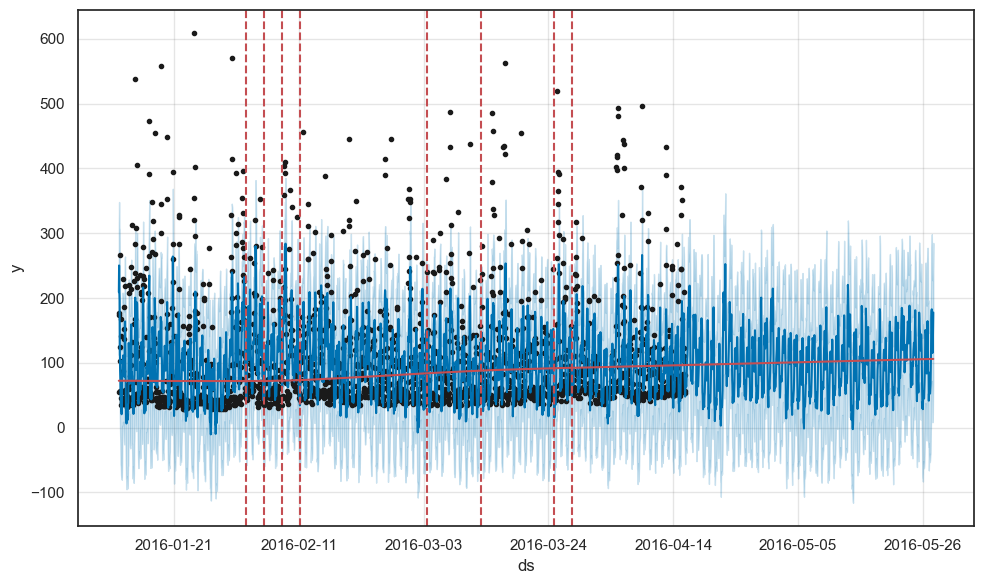

In [132]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast_data)
a = add_changepoints_to_plot(fig.gca(), model, forecast_data)

In [133]:
print(model.params['delta'])

[[ 0.0277141   0.0275618   0.00795834 ... -0.00069119 -0.0226032
  -0.00449782]
 [-0.00595222 -0.0155598  -0.00895851 ... -0.0062116  -0.0260667
   0.00353658]
 [ 0.00456199 -0.0359881   0.015252   ... -0.0246977  -0.0304103
   0.022428  ]
 ...
 [ 0.00451626 -0.0259906  -0.0168716  ...  0.00664629 -0.00181442
   0.00557199]
 [-0.00772865 -0.0190777   0.00128251 ... -0.0279176  -0.0238633
   0.0206336 ]
 [-0.0169607  -0.0133785   0.00823002 ... -0.019497   -0.00289906
   0.0360938 ]]


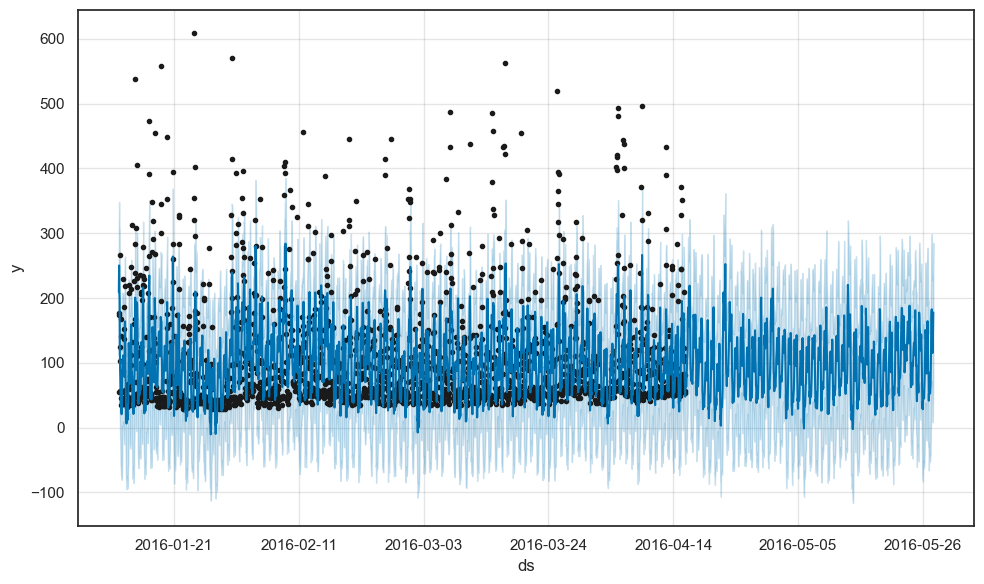

In [134]:
fig4= model.plot(forecast_data)

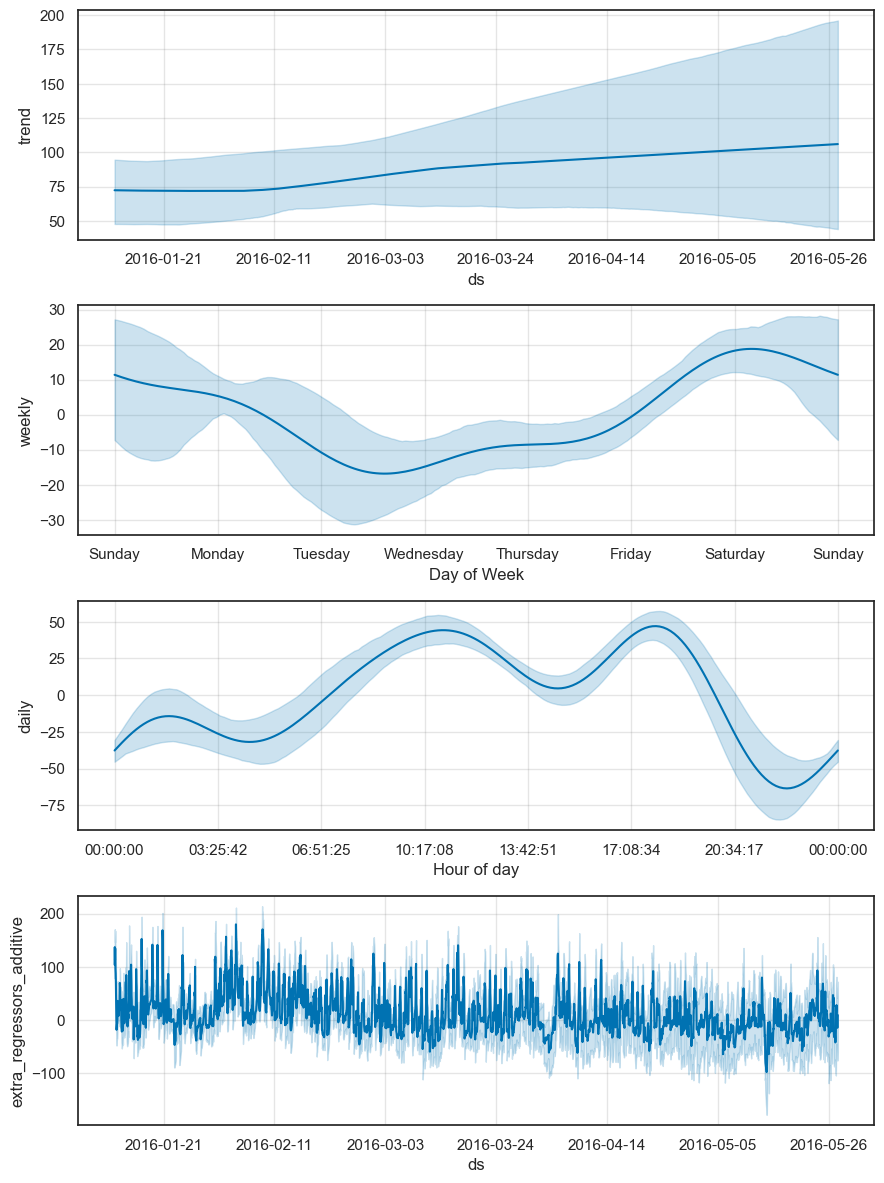

In [135]:
fig5= model.plot_components(forecast_data)

In [136]:
from prophet.utilities import regressor_coefficients
regressor_coefficients(model)
# for temp1, the ridership is down by 724% when compared to other regressors

regressor regressor_mode      center  coef_lower       coef  coef_upper
0          lgt       additive    4.578963    1.743177   2.180205    2.641591
1        temp1       additive   21.062722  -11.981337  -2.581765    4.126525
2         rh_1       additive   40.390336   -0.150946   2.873315    6.573740
3        temp2       additive   19.577574   -9.416331   1.518605    8.750128
4         rh_2       additive   40.864579   -8.327942  -1.228569    4.461748
5        temp3       additive   21.400633    4.922581  16.721025   30.423750
6         rh_3       additive   39.799456   -0.341324   7.182205   12.910685
7        temp4       additive   19.949201   -9.126954  -3.461111    2.448124
8         rh_4       additive   39.460754   -6.269026  -0.419398    4.815877
9        temp5       additive   18.791068  -13.133681  -4.821951    1.807880
10        rh_5       additive   51.897878   -0.114884   0.200329    0.514968
11       temp6       additive    5.927540   -3.450119  -1.322422    1.487280
12        rh_6       additive   67.543798   -0.488112  -0.006403    0.644436
13       temp7       additive   19.371121  -11.981201  -5.084411   -0.689122
14        rh_7       additive   35.609106   -3.247365  -1.293318    0.836243
15       temp8       additive   21.320473    4.466900  10.145631   18.225657
16        rh_8       additive   43.298883   -4.844514  -2.399097   -0.343697
17       temp9       additive   18.579274  -30.300736  -5.492420   12.526246
18        rh_9       additive   41.939367   -3.787260  -1.172600    2.072960
19    temp_out       additive    5.691860   -0.166097   1.492525    3.846819
20       press       additive  755.178227   -0.433988   0.196814    0.672002
21      rh_out       additive   82.593641   -1.187616   0.415690    1.920215
22   windspeed       additive    4.351216    0.150601   1.600860    3.029077
23  visibility       additive   38.932656   -0.062197   0.126634    0.324439
24    dewpoint       additive    2.731190   -6.102154  -2.839857    1.251286
25        hour       additive    0.000000   -0.196106   1.313692    2.548260
26   dayofweek       additive    0.000000   -9.156889  -4.449026    0.876364
27       month       additive    0.000000  -14.020502  -4.653787    3.825931
28        year       additive    0.000000   -0.009331   0.012123    0.040596
29  weekofyear       additive    0.000000   -5.721557   0.200087    7.496662

In [137]:
from prophet.plot import plot_forecast_component 
#fig, axes= plt.subplots(len(regressor_coefficients(model)), figsize=(10, 20))
#for i, regressor in enumerate(regressor_coefficients(model)['regressor']):
    #plot_forecast_component(model, forecast, regressor, axes[i])

#plt.show()

In [138]:
# converting the data from log to normal data
#forecast_data_orig= forecast_data 
#forecast_data_orig['yhat']= np.exp(forecast_data_orig['yhat'])
#forecast_data_orig['yhat_lower']= np.exp(forecast_data_orig['yhat_lower'])
#forecast_data_orig['yhat_upper']= np.exp(forecast_data_orig['yhat_upper'])

In [139]:
#fig6= model.plot(forecast_data_orig)

In [140]:
from prophet.diagnostics import cross_validation, performance_metrics

cv_result = cross_validation(model, horizon='41 days', period='41 days', initial= '50 days')
df_fm= performance_metrics(cv_result)
df_fm

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]13:29:34 - cmdstanpy - INFO - CmdStan installation C:\Anaconda\envs\tensorflow\lib\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
13:29:34 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
13:29:34 - cmdstanpy - INFO - CmdStan start processing

chain 1 |                                                                                                | 00:00 Status

chain 2 |                                                                                                | 00:00 Status


chain 3 |                                                                                                | 00:00 Status



chain 4 |                                                                                                | 00:00 Status


chain 3 |██████████████████████████                                       | 00:43 Iterati


13:31:49 - cmdstanpy - INFO - CmdStan done processing.
13:31:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, c

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:17<00:00, 137.75s/it]


horizon           mse        rmse        mae      mape     mdape  \
0    4 days 02:00:00   5187.333667   72.023147  51.020669  0.609641  0.557536   
1    4 days 03:00:00   5195.690306   72.081137  51.216683  0.614652  0.567426   
2    4 days 04:00:00   5211.370321   72.189821  51.568005  0.623084  0.582226   
3    4 days 05:00:00   5229.995305   72.318706  51.926631  0.630135  0.593614   
4    4 days 06:00:00   5231.010861   72.325728  51.953226  0.632325  0.593614   
..               ...           ...         ...        ...       ...       ...   
882 40 days 20:00:00  11679.102221  108.069895  76.849477  0.783355  0.718659   
883 40 days 21:00:00  11723.381672  108.274566  77.191783  0.787381  0.726772   
884 40 days 22:00:00  11776.473794  108.519463  77.739579  0.794721  0.751266   
885 40 days 23:00:00  11802.156309  108.637730  77.999098  0.800806  0.780339   
886 41 days 00:00:00  11855.100688  108.881131  78.574466  0.812054  0.795522   

        smape  coverage  
0    0.622421  0.918367  
1    0.631533  0.918367  
2    0.648620  0.918367  
3    0.662953  0.918367  
4    0.666741  0.918367  
..        ...       ...  
882  1.060879  0.857143  
883  1.070797  0.857143  
884  1.086377  0.857143  
885  1.102695  0.857143  
886  1.120527  0.857143  

[887 rows x 8 columns]

In [298]:
df_fm.head()

horizon          mse       rmse        mae      mape     mdape  \
0 4 days 02:00:00  5658.506582  75.223046  55.325518  0.695215  0.548584   
1 4 days 03:00:00  5691.833903  75.444244  55.788123  0.706668  0.554876   
2 4 days 04:00:00  5740.158450  75.763833  56.448859  0.722526  0.556203   
3 4 days 05:00:00  5793.629782  76.115897  57.133805  0.736457  0.557863   
4 4 days 06:00:00  5814.652073  76.253866  57.480060  0.747427  0.560392   

      smape  coverage  
0  0.714589  0.928571  
1  0.731589  0.928571  
2  0.750916  0.928571  
3  0.769826  0.928571  
4  0.786953  0.928571

In [299]:
df_fm.mean()

horizon     22 days 13:00:00
mse               7453.34005
rmse               84.311928
mae                 63.19633
mape                0.781764
mdape               0.690632
smape               0.911793
coverage            0.887583
dtype: object

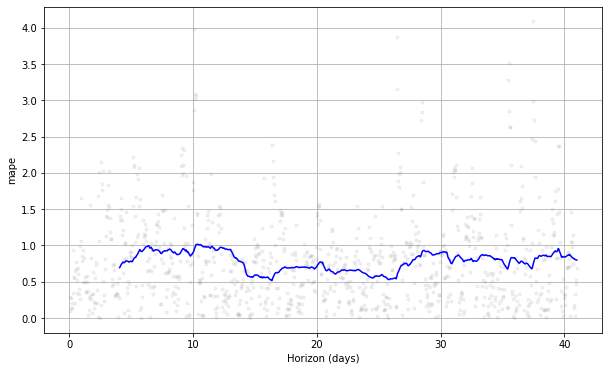

In [300]:
from prophet.plot import plot_cross_validation_metric

fig4 = plot_cross_validation_metric(cv_result, metric='mape')

In [301]:
df_fm['mape'].values[0]

0.6952154398285433

In [43]:
import itertools
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from prophet.diagnostics import cross_validation, performance_metrics

## Contributing regressors

In [115]:
ed_fm2= ed_fm[['ds','y','lgt', 'rh_1', 'temp3', 'rh_3', 'rh_5', 'temp6', 'rh_6', 'temp7', 'temp8', 'press', 'rh_out', 'windspeed', 'visibility', 'dewpoint', 'hour', 'year']]

In [116]:
train_2= ed_fm2[(ed_fm2['ds'] >= '2016-01-11') & (ed_fm2['ds'] <= '2016-04-16')]
test_2= ed_fm2[(ed_fm2['ds'] >'2016-04-16')]

In [259]:
#model_2= Prophet(interval_width=0.95, changepoint_prior_scale=0.5)
model_2= Prophet(mcmc_samples=300)

In [260]:
model_2.add_regressor('lgt')   
model_2.add_regressor('rh_1')
model_2.add_regressor('temp3')
model_2.add_regressor('rh_3')   
model_2.add_regressor('rh_5')
model_2.add_regressor('temp6')   
model_2.add_regressor('rh_6')
model_2.add_regressor('temp7')
model_2.add_regressor('temp8')
model_2.add_regressor('press')
model_2.add_regressor('rh_out')   
model_2.add_regressor('windspeed')
model_2.add_regressor('visibility')
model_2.add_regressor('dewpoint')
model_2.add_regressor('hour', standardize=False)
model_2.add_regressor('year', standardize=False)

In [261]:
model_2.fit(train_2)

17:28:51 - cmdstanpy - INFO - CmdStan installation C:\Users\benny\AppData\Roaming\Python\Python39\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
17:28:51 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
17:28:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:36:12 - cmdstanpy - INFO - CmdStan done processing.
17:36:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Excep

In [262]:
train_2.columns

Index(['ds', 'y', 'lgt', 'rh_1', 'temp3', 'rh_3', 'rh_5', 'temp6', 'rh_6',
       'temp7', 'temp8', 'press', 'rh_out', 'windspeed', 'visibility',
       'dewpoint', 'hour', 'year'],
      dtype='object')

In [263]:
future_da2= model_2.make_future_dataframe(periods=1002, freq= 'H')  #1002

In [264]:
future_da2['lgt']= ed_fm2['lgt']
future_da2['rh_1']= ed_fm2['rh_1']
future_da2['temp3']= ed_fm2['temp3']
future_da2['rh_3']= ed_fm2['rh_3']
future_da2['rh_5']= ed_fm2['rh_5']
future_da2['temp6']= ed_fm2['temp6']
future_da2['rh_6']= ed_fm2['rh_6']
future_da2['temp7']= ed_fm2['temp7']
future_da2['temp8']= ed_fm2['temp8']
future_da2['press']= ed_fm2['press']
future_da2['rh_out']= ed_fm2['rh_out']
future_da2['windspeed']= ed_fm2['windspeed']
future_da2['visibility']= ed_fm2['visibility']
future_da2['dewpoint']= ed_fm2['dewpoint']
future_da2['hour']= ed_fm2['hour']
future_da2['year']= ed_fm2['year']

In [265]:
forecast_da2 = model_2.predict(future_da2)

In [266]:
forecast_da2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
3285 2016-05-27 14:00:00  157.743082   52.047464  261.885214
3286 2016-05-27 15:00:00  150.008172   47.746483  253.114673
3287 2016-05-27 16:00:00  163.816539   56.315585  257.031016
3288 2016-05-27 17:00:00  185.761149   88.262859  285.966411
3289 2016-05-27 18:00:00  206.616529  106.529602  312.375082

In [267]:
from sklearn.metrics import r2_score
print('r2:', r2_score(ed_fm2['y'], forecast_da2['yhat']))

r2: 0.3194404329466999


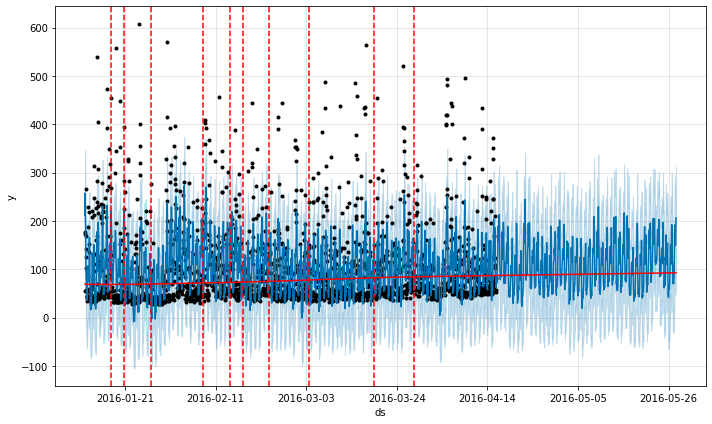

In [268]:
from prophet.plot import add_changepoints_to_plot
fig = model_2.plot(forecast_da2)
a = add_changepoints_to_plot(fig.gca(), model_2, forecast_da2)

In [269]:
print(model_2.params['delta'])

[[ 0.0637      0.00398191 -0.0180775  ... -0.0104722  -0.0199489
   0.0221347 ]
 [-0.0135862   0.0667723   0.0194786  ... -0.00644285  0.0204508
  -0.0505418 ]
 [-0.0115962  -0.00086173  0.03769    ...  0.00099036  0.00427413
   0.0238333 ]
 ...
 [-0.0472963   0.0928046   0.0440367  ... -0.0170938   0.0233101
  -0.0334621 ]
 [-0.00231237 -0.00999994  0.0559689  ...  0.00910057 -0.00429654
   0.00392069]
 [-0.0126773  -0.00019044  0.016084   ...  0.0378652   0.00333698
  -0.0298458 ]]


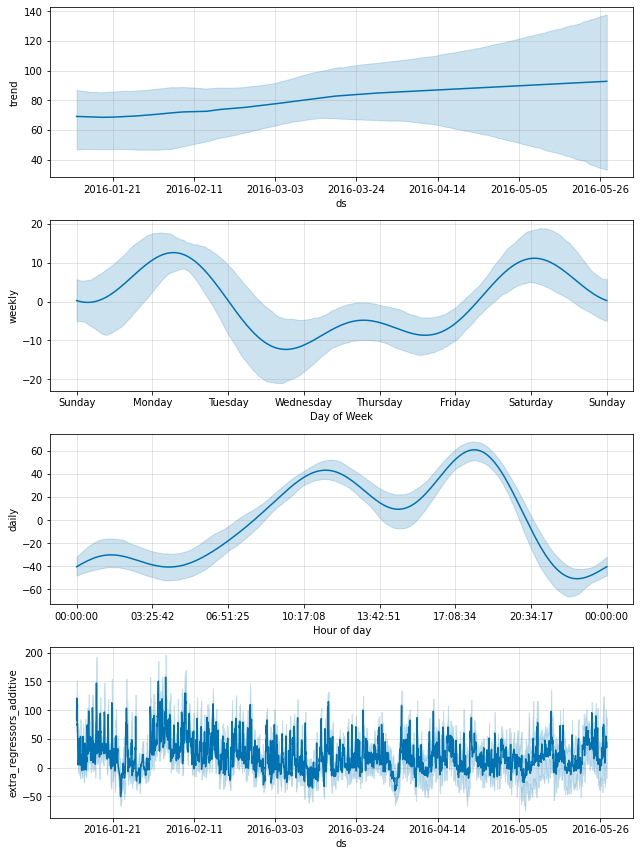

In [270]:
fig5= model_2.plot_components(forecast_da2)

In [271]:
from prophet.utilities import regressor_coefficients
regressor_coefficients(model_2)

regressor regressor_mode      center  coef_lower       coef  coef_upper
0          lgt       additive    4.578963    1.897778   2.229821    2.493208
1         rh_1       additive   40.390336   -2.800806   1.661945    4.315588
2        temp3       additive   21.400633   12.439036  15.562518   18.535694
3         rh_3       additive   39.799456   -1.412203   2.797659    6.320792
4         rh_5       additive   51.897878   -0.536189  -0.276187    0.005121
5        temp6       additive    5.927540   -2.467491   0.997968    4.966352
6         rh_6       additive   67.543798   -0.172823   0.143820    0.788213
7        temp7       additive   19.371121   -9.998864  -6.353918   -0.981994
8        temp8       additive   21.320473   -2.453162   3.224320    8.255758
9        press       additive  755.178227   -0.101469   0.299787    0.673620
10      rh_out       additive   82.593641   -0.153291   0.271635    0.640129
11   windspeed       additive    4.351216   -0.599412   1.114457    2.740506
12  visibility       additive   38.932656    0.020607   0.162607    0.308576
13    dewpoint       additive    2.731190  -10.512917  -6.594586   -2.429218
14        hour       additive    0.000000    0.109497   0.936631    2.303815
15        year       additive    0.000000   -0.001591   0.005348    0.012176

In [272]:
from prophet.diagnostics import cross_validation, performance_metrics

cv_result2 = cross_validation(model_2, horizon='41 days', period='30 days', initial= '50 days')
df_fm_2= performance_metrics(cv_result2)
df_fm_2

  0%|          | 0/1 [00:00<?, ?it/s]

17:38:08 - cmdstanpy - INFO - CmdStan installation C:\Users\benny\AppData\Roaming\Python\Python39\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
17:38:08 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
17:38:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:41:07 - cmdstanpy - INFO - CmdStan done processing.
17:41:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, co

horizon          mse       rmse        mae      mape     mdape  \
0    4 days 02:00:00  5086.615872  71.320515  46.391309  0.497250  0.393427   
1    4 days 03:00:00  5086.368602  71.318782  46.373292  0.497021  0.393427   
2    4 days 04:00:00  5086.520387  71.319846  46.412042  0.497951  0.393427   
3    4 days 05:00:00  5087.201625  71.324621  46.472914  0.499096  0.393427   
4    4 days 06:00:00  5087.786810  71.328724  46.492065  0.500796  0.403212   
..               ...          ...        ...        ...       ...       ...   
882 40 days 20:00:00  6371.524044  79.821827  53.891241  0.520691  0.463383   
883 40 days 21:00:00  6328.101094  79.549363  53.292543  0.515873  0.436524   
884 40 days 22:00:00  6307.676753  79.420884  52.905725  0.512465  0.433215   
885 40 days 23:00:00  6268.609059  79.174548  52.311636  0.504518  0.411981   
886 41 days 00:00:00  6251.033099  79.063475  51.922672  0.498302  0.403994   

        smape  coverage  
0    0.419384  0.928571  
1    0.418903  0.928571  
2    0.419879  0.928571  
3    0.421178  0.928571  
4    0.421461  0.928571  
..        ...       ...  
882  0.435238  0.918367  
883  0.431613  0.918367  
884  0.429009  0.918367  
885  0.423603  0.918367  
886  0.419106  0.918367  

[887 rows x 8 columns]

In [273]:
df_fm_2.mean()

horizon     22 days 13:00:00
mse              5000.573295
rmse               68.575072
mae                43.182912
mape                0.438475
mdape               0.347985
smape               0.388834
coverage            0.929434
dtype: object

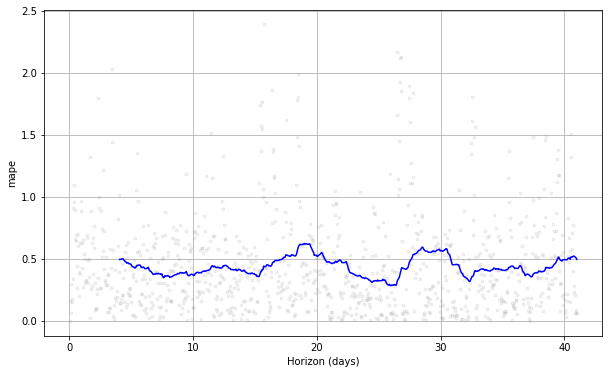

In [274]:
from prophet.plot import plot_cross_validation_metric

fig4 = plot_cross_validation_metric(cv_result2, metric='mape')

In [ ]:
#modelling with rolling window 

In [126]:
# utlizing winsorizing techinque to remove outliers
from scipy import stats
df4= ed_fm.copy().dropna()
df4['y']= stats.mstats.winsorize(df4['y'], limits=(0, .05), axis=0)

<AxesSubplot:title={'center':'appliance energy usage'}, xlabel='ds'>

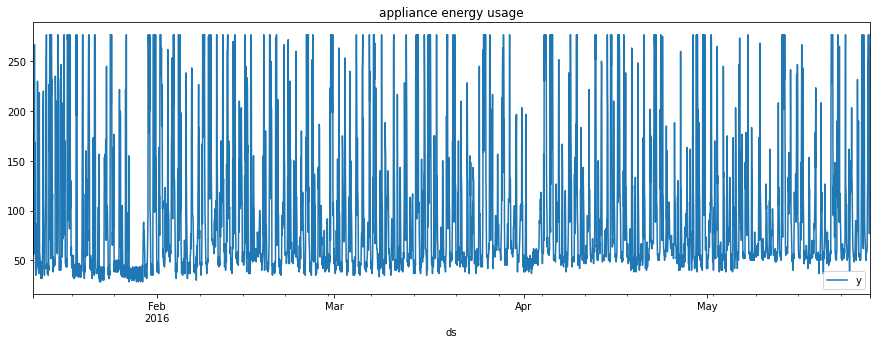

In [127]:
df4.plot(kind='line', x='ds', y='y', figsize=(15,5), title='appliance energy usage')

In [164]:
ed_fm

ds           y        lgt      temp1       rh_1  \
0    2016-01-11 17:00:00   55.000000  35.000000  19.890000  46.502778   
1    2016-01-11 18:00:00  176.666667  51.666667  19.897778  45.879028   
2    2016-01-11 19:00:00  173.333333  25.000000  20.495556  52.805556   
3    2016-01-11 20:00:00  125.000000  35.000000  20.961111  48.453333   
4    2016-01-11 21:00:00  103.333333  23.333333  21.311667  45.768333   
...                  ...         ...        ...        ...        ...   
3285 2016-05-27 14:00:00  101.666667   1.666667  25.544444  46.638889   
3286 2016-05-27 15:00:00   76.666667   0.000000  25.500000  45.677639   
3287 2016-05-27 16:00:00  135.000000   0.000000  25.487778  46.250000   
3288 2016-05-27 17:00:00  180.000000   3.333333  25.533333  46.783333   
3289 2016-05-27 18:00:00  430.000000  10.000000  25.500000  46.600000   

          temp2       rh_2      temp3       rh_3      temp4  ...       press  \
0     19.200000  44.626528  19.790000  44.897778  18.932778  ...  733.750000   
1     19.268889  44.438889  19.770000  44.863333  18.908333  ...  734.266667   
2     19.925556  46.061667  20.052222  47.227361  18.969444  ...  734.791667   
3     20.251111  45.632639  20.213889  47.268889  19.190833  ...  735.283333   
4     20.587778  44.961111  20.373333  46.164444  19.425556  ...  735.566667   
...         ...        ...        ...        ...        ...  ...         ...   
3285  26.421369  41.205054  28.397778  41.160000  24.666667  ...  755.800000   
3286  26.154762  41.041238  28.240000  40.306667  24.694444  ...  755.675000   
3287  26.000000  41.736190  27.953333  40.607778  24.700000  ...  755.375000   
3288  25.772190  42.495476  27.164444  41.247778  24.700000  ...  755.200000   
3289  25.264286  42.971429  26.823333  41.156667  24.700000  ...  755.200000   

         rh_out  windspeed  visibility   dewpoint  hour  dayofweek  month  \
0     92.000000   6.166667   53.416667   5.050000  17.0        0.0    1.0   
1     91.583333   5.416667   40.000000   4.658333  18.0        0.0    1.0   
2     89.750000   6.000000   40.000000   4.391667  19.0        0.0    1.0   
3     87.583333   6.000000   40.000000   4.016667  20.0        0.0    1.0   
4     87.416667   6.000000   40.000000   3.816667  21.0        0.0    1.0   
...         ...        ...         ...        ...   ...        ...    ...   
3285  59.000000   2.000000   21.583333  13.483333  14.0        4.0    5.0   
3286  57.333333   2.000000   21.833333  13.266667  15.0        4.0    5.0   
3287  55.000000   2.416667   22.583333  13.283333  16.0        4.0    5.0   
3288  55.833333   3.416667   24.083333  13.316667  17.0        4.0    5.0   
3289  57.000000   4.000000   27.000000  13.200000  18.0        4.0    5.0   

        year  weekofyear  
0     2016.0         2.0  
1     2016.0         2.0  
2     2016.0         2.0  
3     2016.0         2.0  
4     2016.0         2.0  
...      ...         ...  
3285  2016.0        21.0  
3286  2016.0        21.0  
3287  2016.0        21.0  
3288  2016.0        21.0  
3289  2016.0        21.0  

[3290 rows x 32 columns]

In [165]:

df5= ed_fm[['ds', 'y']]

df5.loc[df5['y'] > 500, 'y']= None #removing values greater than 500

In [166]:
df5

ds           y
0    2016-01-11 17:00:00   55.000000
1    2016-01-11 18:00:00  176.666667
2    2016-01-11 19:00:00  173.333333
3    2016-01-11 20:00:00  125.000000
4    2016-01-11 21:00:00  103.333333
...                  ...         ...
3285 2016-05-27 14:00:00  101.666667
3286 2016-05-27 15:00:00   76.666667
3287 2016-05-27 16:00:00  135.000000
3288 2016-05-27 17:00:00  180.000000
3289 2016-05-27 18:00:00  430.000000

[3290 rows x 2 columns]

12:02:47 - cmdstanpy - INFO - Chain [1] start processing
12:02:47 - cmdstanpy - INFO - Chain [1] done processing


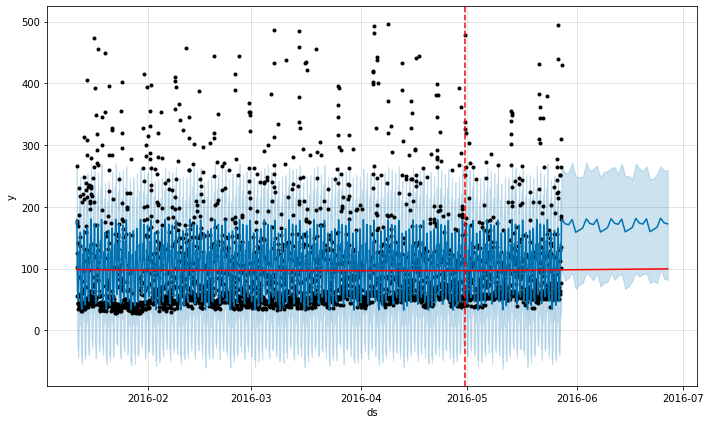

In [168]:
mod_map= Prophet(uncertainty_samples=1000)
mod_map.fit(df5)
future= mod_map.make_future_dataframe(periods=30)
forecast_map= mod_map.predict(future)

fig= mod_map.plot(forecast_map)
add_changepoints_to_plot(fig.gca(), mod_map, forecast_map)
plt.show()

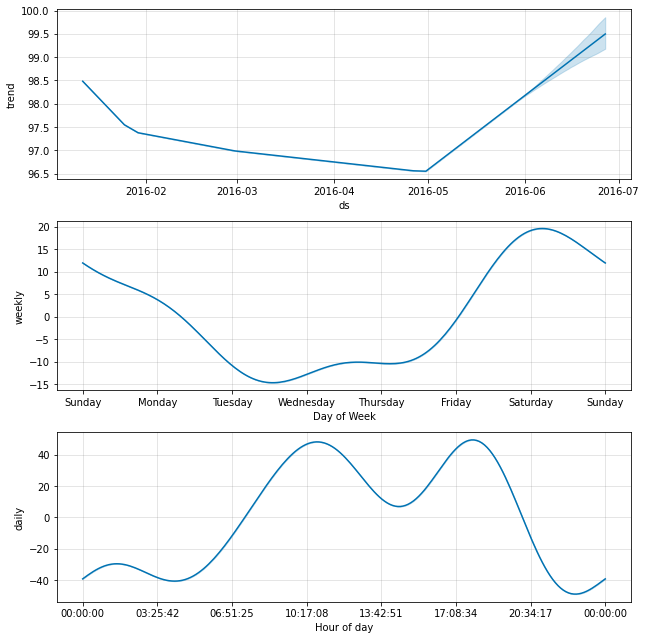

In [169]:
fig2= model.plot_components(forecast_map)
plt.show()

In [174]:
m0= mod_map
f0=forecast_map

In [170]:
samples = mod_map.predictive_samples(future)

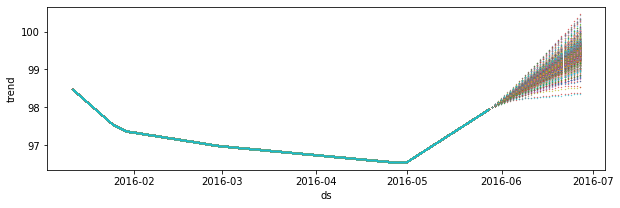

In [173]:
samples = mod_map.predictive_samples(future)

plt.figure(figsize=(10,3))
for idx in range (mod_map.uncertainty_samples):
    plt.scatter(future['ds'], samples['trend'][:,idx], s=.1, alpha=1)
plt.xlabel('ds')
plt.ylabel('trend')
plt.show()

In [ ]:
# modelling with  mcmc_samples Markov Chain 

15:23:40 - cmdstanpy - INFO - CmdStan installation C:\Users\benny\AppData\Roaming\Python\Python39\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
15:23:40 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
15:23:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:25:52 - cmdstanpy - INFO - CmdStan done processing.
15:25:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to l

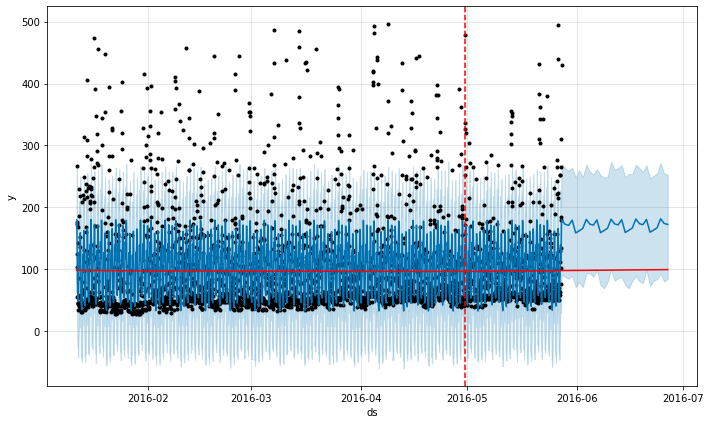

In [231]:
mod_m= Prophet(mcmc_samples=300)
mod_m.fit(df5)
future= mod_m.make_future_dataframe(periods=30)
forecast_mc= mod_map.predict(future)

fig= mod_m.plot(forecast_mc)
add_changepoints_to_plot(fig.gca(), mod_map, forecast_mc)
plt.show()

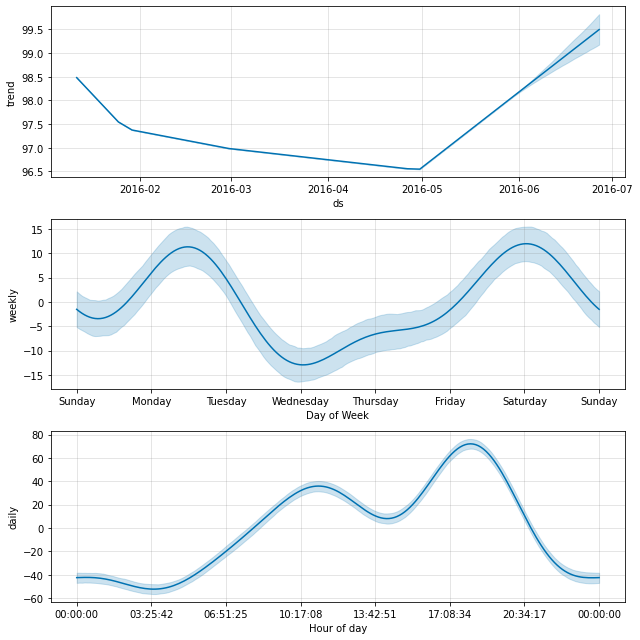

In [232]:
fig2= mod_m.plot_components(forecast_mc)
plt.show()

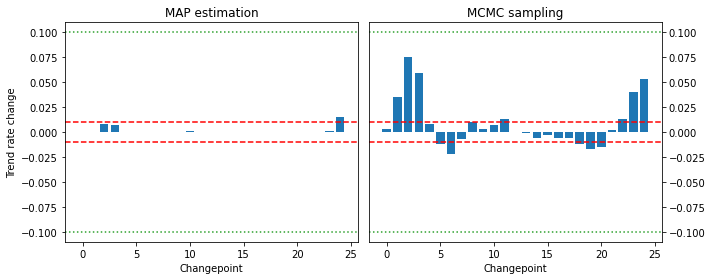

In [233]:
fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_subplot(121)
ax1.bar(np.arange(25), np.nanmean(mod_map.params['delta'], axis=0))
ax1.set_title('MAP estimation')
ax1.set_xlabel('Changepoint')
ax1.set_ylabel('Trend rate change')
ax1.axhline(y=0.01, color='r', ls='--')
ax1.axhline(y=-0.01, color='r', ls='--')
ax1.axhline(y=0.1, color='tab:green', ls=':')
ax1.axhline(y=-0.1, color='tab:green', ls=':')

ax2 = fig.add_subplot(122)
ax2.bar(np.arange(25), np.nanmean(mod_m.params['delta'], axis=0))
ax2.set_xlabel('Changepoint')
ax2.axhline(y=0.01, color='r', ls='--')
ax2.axhline(y=-0.01, color='r', ls='--')
ax2.axhline(y=0.1, color='tab:green', ls=':')
ax2.axhline(y=-0.1, color='tab:green', ls=':')
ax2.set_title('MCMC sampling')
ax2.yaxis.tick_right()

ylim = max([abs(val) for val in ax1.get_ylim() + ax2.get_ylim()])
ax1.set_ylim(-ylim, ylim)
ax2.set_ylim(-ylim, ylim)

plt.tight_layout()
plt.show()

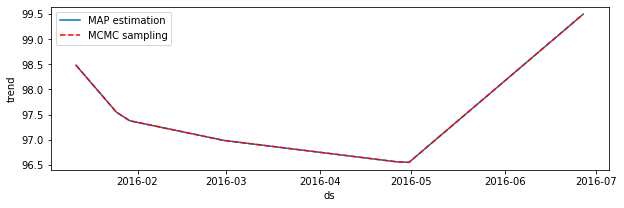

In [234]:
plt.figure(figsize=(10, 3))

plt.plot(f0['ds'], f0['trend'], color='#0072B2', label='MAP estimation')

plt.plot(forecast_mc['ds'], forecast_mc['trend'], color='r', ls='--', label='MCMC sampling')

plt.ylabel('trend')
plt.xlabel('ds')
plt.legend()
plt.show()

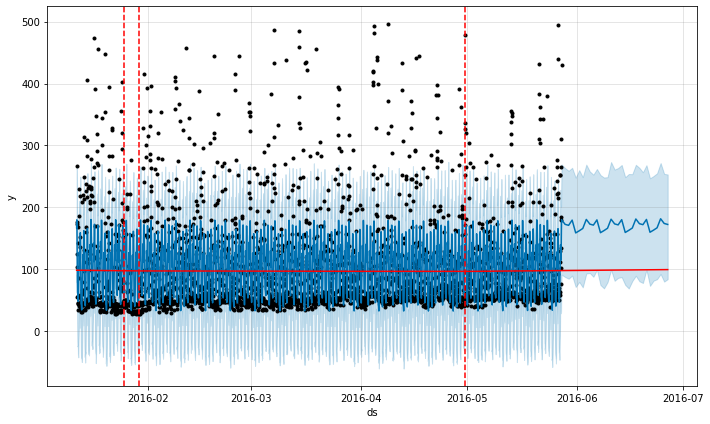

In [235]:
fig = mod_m.plot(forecast_mc)
add_changepoints_to_plot(fig.gca(), mod_m, forecast_mc, threshold=0.05)
plt.show()

#fig = model.plot(forecast_mc)
#add_changepoints_to_plot(fig.gca(), mod_m, forecast_mc, threshold=0.1)
#plt.show()
#threshold removes the number of chnagepoints
#0.05 is the default settings

In [186]:
# Saving for use later
m1 = mod_m
f1 = forecast_mc

12:44:23 - cmdstanpy - INFO - CmdStan installation C:\Users\benny\AppData\Roaming\Python\Python39\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
12:44:23 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
12:44:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:45:33 - cmdstanpy - INFO - CmdStan done processing.
12:45:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, col

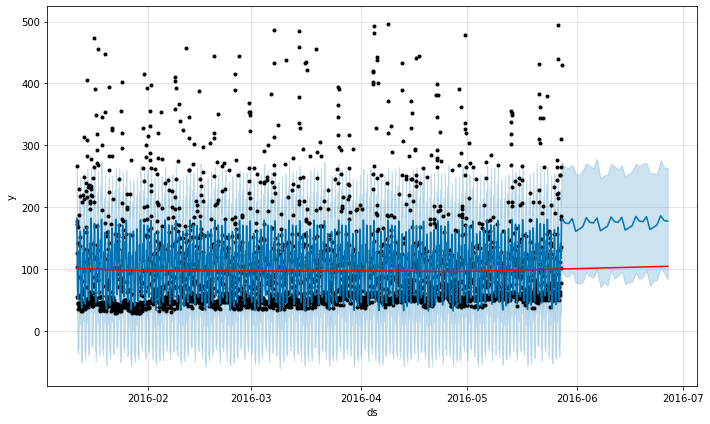

In [188]:
mod_ma = Prophet(changepoint_prior_scale=0.03,
                mcmc_samples=300)
mod_ma.fit(df5)
future = mod_ma.make_future_dataframe(periods=30)
forecast_mcm = mod_ma.predict(future)
fig = mod_ma.plot(forecast_mcm)
add_changepoints_to_plot(fig.gca(), mod_ma, forecast_mcm, threshold=0.05)
plt.show()

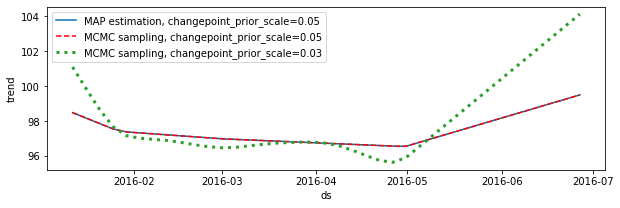

In [189]:
plt.figure(figsize=(10, 3))

plt.plot(f0['ds'],
         f0['trend'],
         color='#0072B2',
         label='MAP estimation, changepoint_prior_scale=0.05')

plt.plot(f1['ds'],
         f1['trend'],
         color='r',
         ls='--',
         label='MCMC sampling, changepoint_prior_scale=0.05')

plt.plot(forecast_mcm['ds'],
         forecast_mcm['trend'],
         color='tab:green',
         ls=':',
         lw=3,
         label='MCMC sampling, changepoint_prior_scale=0.03')

plt.ylabel('trend')
plt.xlabel('ds')
plt.legend()
plt.show()

In [190]:
dff_cv= cross_validation(mod_ma, horizon='30 days', period='30 days', initial='96 days')

  0%|          | 0/1 [00:00<?, ?it/s]

13:23:04 - cmdstanpy - INFO - CmdStan installation C:\Users\benny\AppData\Roaming\Python\Python39\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
13:23:04 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
13:23:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:23:48 - cmdstanpy - INFO - CmdStan done processing.
13:23:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Excep